<a href="https://colab.research.google.com/github/sashanikina/NS_lab2/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.utils.data as data
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
import cv2
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 8600 to 9908
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1309 non-null   int32  
 1   Open    1309 non-null   float64
dtypes: float64(1), int32(1)
memory usage: 15.5 KB
          Date        Open
8600  20150121  108.949997
8601  20150122  110.260002
8602  20150123  112.300003
8603  20150126  113.739998
8604  20150127  112.419998
...        ...         ...
9904  20200326  246.520004
9905  20200327  252.750000
9906  20200330  250.740005
9907  20200331  255.600006
9908  20200401  246.500000

[1309 rows x 2 columns]


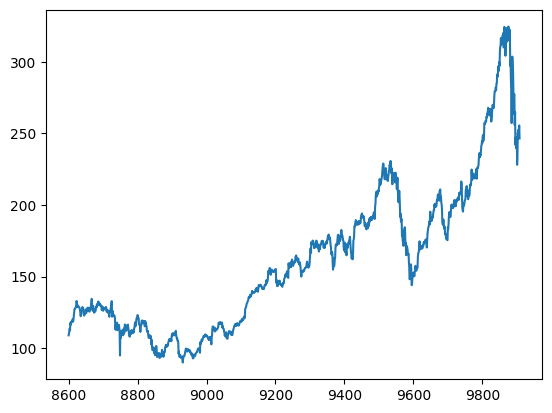

In [ ]:
#df = pd.read_csv("./archive/stocks.csv")
df = pd.read_csv("./AAPL/AAPL.csv")
df = df.drop('High' , axis = 1)
df = df.drop('Low' , axis = 1)
df = df.drop('Close' , axis = 1)
df = df.drop('Adj Close' , axis = 1)
df = df.drop('Volume' , axis = 1)
df['Date'] = df['Date'].str.replace("-","").astype(int)
df = df.sort_values(by='Date', ignore_index=True)
df = df[8600:]
timeseries = df[["Open"]].values.astype('float32')
df.info()
print(df)
plt.plot(df['Open'])
plt.show()

In [ ]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 50
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=24)

torch.Size([827, 50, 1]) torch.Size([827, 50, 1])
torch.Size([382, 50, 1]) torch.Size([382, 50, 1])


C:\Users\slava\AppData\Local\Temp\ipykernel_31628\496344701.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn1 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        output, hidden = self.rnn1(output, hidden)
        output = self.linear(output)

        return output

In [ ]:
#RNN Adam

In [ ]:
rnn = RNN().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [ ]:
n_epochs = 400
train_loss = []
test_loss_adam = []
for epoch in range(n_epochs):
    rnn.train()
    batch_loss = []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = rnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    # Валидация
    rnn.eval()
    with torch.no_grad():
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = rnn(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        X_test = X_test.cuda()
        y_pred = rnn(X_test)
        y_test = y_test.cuda()
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_loss_adam.append(test_rmse.item())
    print("%d: среднеквадратичное отклонение на train - %.4f, среднеквадратичное отклонение на test - %.4f" % (epoch, train_rmse, test_rmse))
    print("{}: функция ошибки - {:.5f}".format(epoch, loss.item()))
    print()

0: среднеквадратичное отклонение на train - 130.3320, среднеквадратичное отклонение на test - 216.1044
0: функция ошибки - 16918.49805

1: среднеквадратичное отклонение на train - 128.3397, среднеквадратичное отклонение на test - 214.1089
1: функция ошибки - 19429.96875

2: среднеквадратичное отклонение на train - 126.4483, среднеквадратичное отклонение на test - 212.2140
2: функция ошибки - 19614.25391

3: среднеквадратичное отклонение на train - 124.6254, среднеквадратичное отклонение на test - 210.3868
3: функция ошибки - 13692.29688

4: среднеквадратичное отклонение на train - 122.8478, среднеквадратичное отклонение на test - 208.6046
4: функция ошибки - 14649.09570

5: среднеквадратичное отклонение на train - 121.1008, среднеквадратичное отклонение на test - 206.8524
5: функция ошибки - 14799.08789

6: среднеквадратичное отклонение на train - 119.3827, среднеквадратичное отклонение на test - 205.1286
6: функция ошибки - 13271.19727

7: среднеквадратичное отклонение на train - 117.

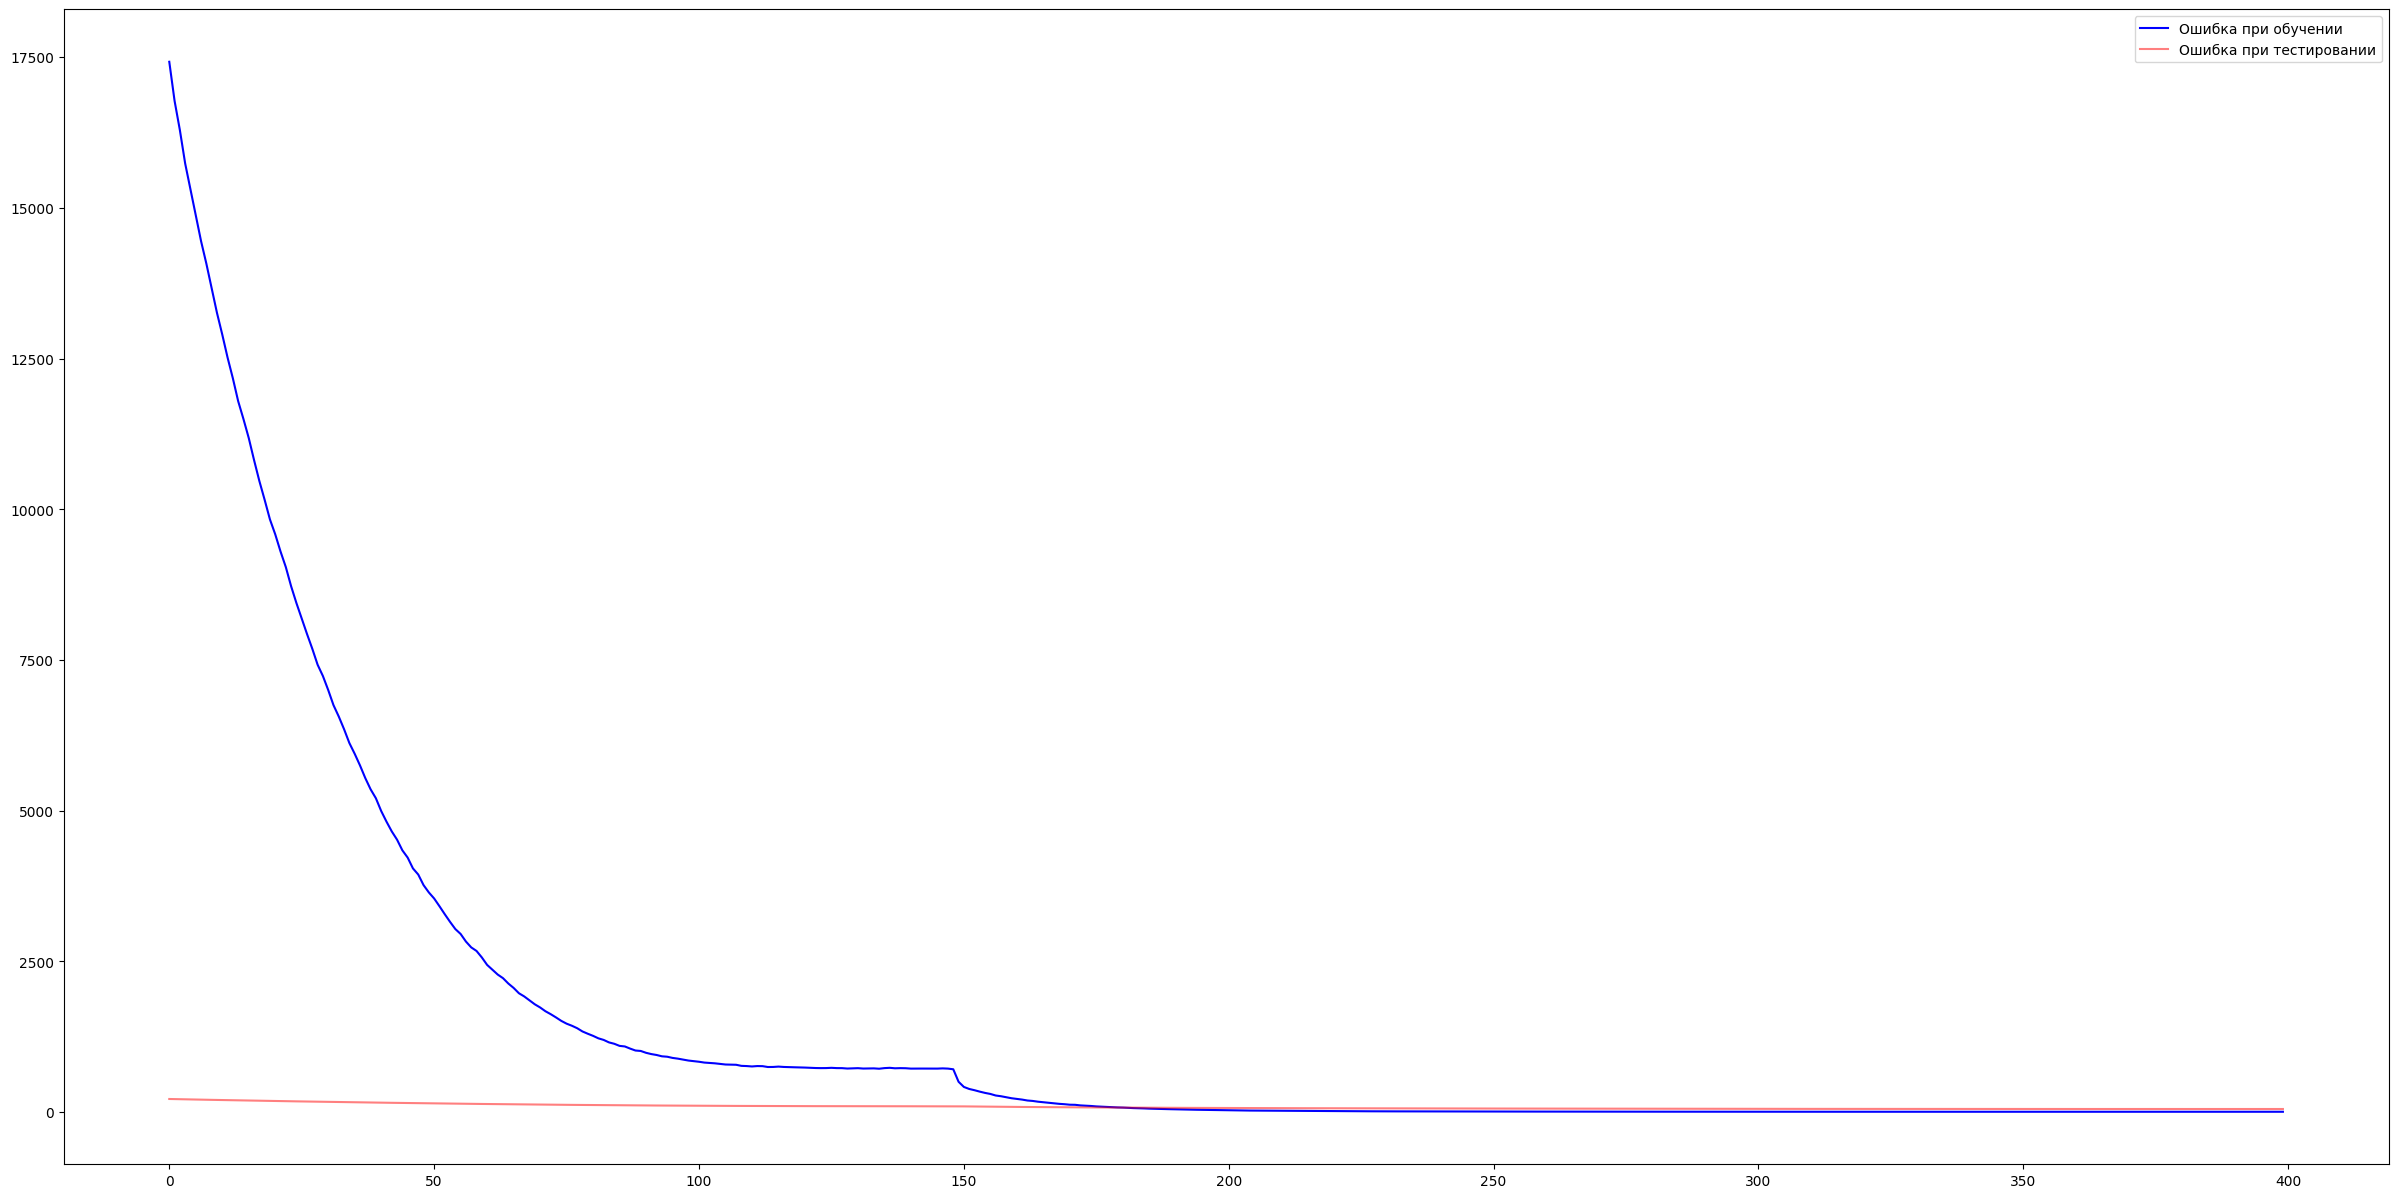

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(train_loss, c='b', label = 'Ошибка при обучении')
plt.plot(test_loss_adam, c='r', label = 'Ошибка при тестировании', alpha = 0.5)
plt.legend()
plt.show()

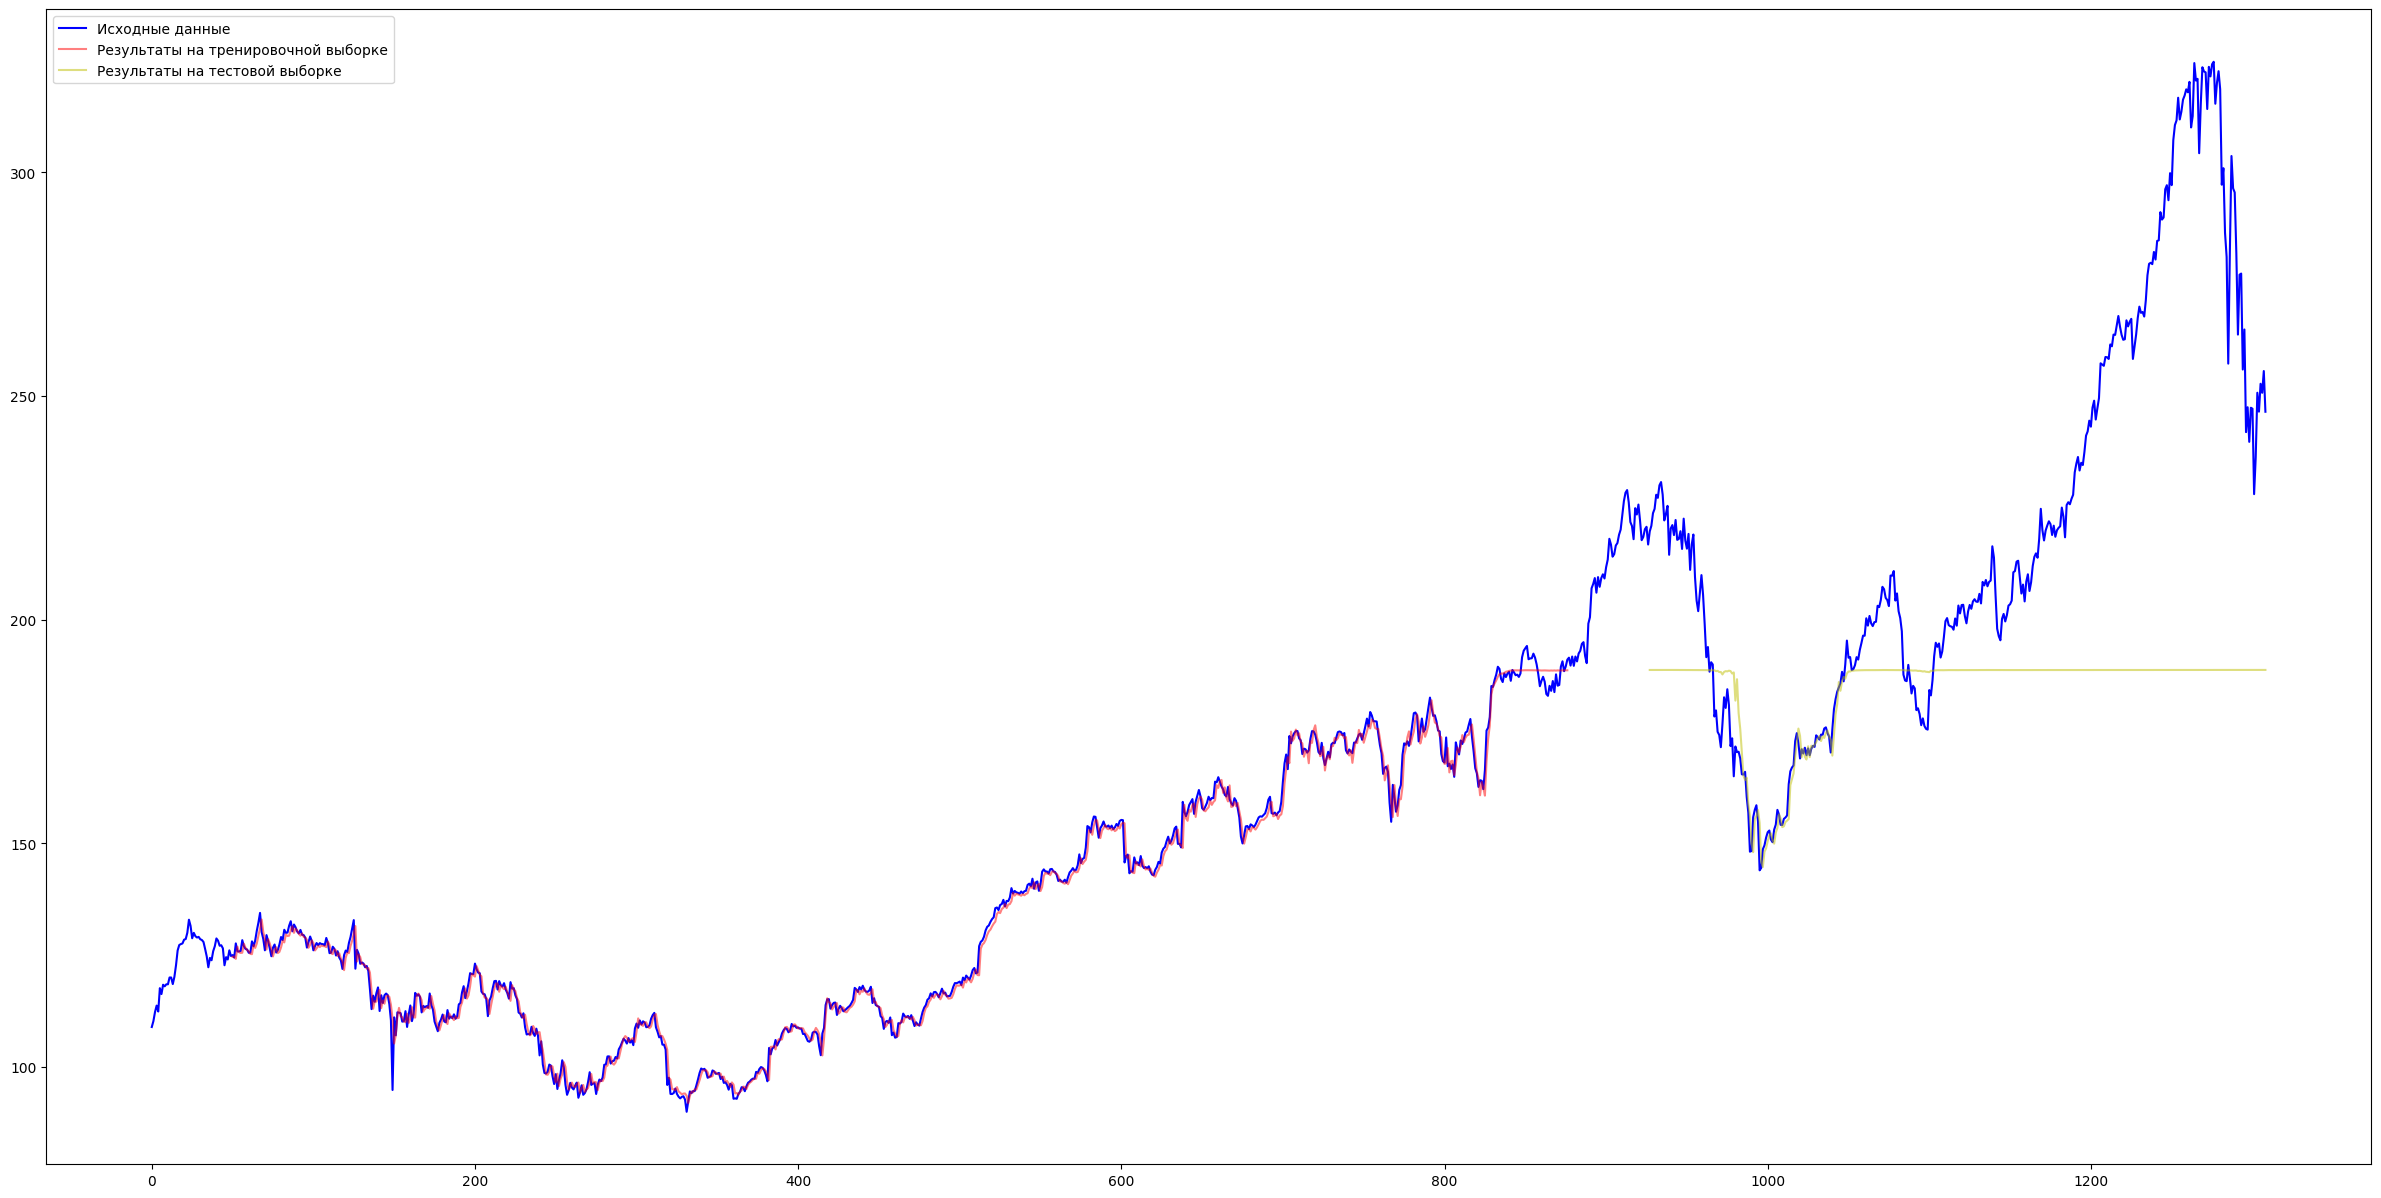

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = rnn(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = rnn(X_train)[:, -1, :].cpu()
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = rnn(X_test)[:, -1, :].cpu()
plt.figure(figsize=(30,15))
plt.plot(timeseries, c='b', label = 'Исходные данные')
plt.plot(train_plot, c='r', label = 'Результаты на тренировочной выборке', alpha = 0.5)
plt.plot(test_plot, c='y', label = 'Результаты на тестовой выборке', alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#RNN RMSprop

In [ ]:
rnn = RNN().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)

In [ ]:
n_epochs = 400
train_loss = []
test_loss_rms = []
for epoch in range(n_epochs):
    rnn.train()
    batch_loss = []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = rnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    # Валидация
    rnn.eval()
    with torch.no_grad():
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = rnn(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        X_test = X_test.cuda()
        y_pred = rnn(X_test)
        y_test = y_test.cuda()
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_loss_rms.append(test_rmse.item())
    print("%d: среднеквадратичное отклонение на train - %.4f, среднеквадратичное отклонение на test - %.4f" % (epoch, train_rmse, test_rmse))
    print("{}: функция ошибки - {:.5f}".format(epoch, loss.item()))
    print()

0: среднеквадратичное отклонение на train - 126.1604, среднеквадратичное отклонение на test - 211.9251
0: функция ошибки - 18428.39648

1: среднеквадратичное отклонение на train - 123.3997, среднеквадратичное отклонение на test - 209.1579
1: функция ошибки - 17669.72070

2: среднеквадратичное отклонение на train - 121.1453, среднеквадратичное отклонение на test - 206.8969
2: функция ошибки - 15985.73633

3: среднеквадратичное отклонение на train - 119.1254, среднеквадратичное отклонение на test - 204.8703
3: функция ошибки - 13818.38574

4: среднеквадратичное отклонение на train - 117.2333, среднеквадратичное отклонение на test - 202.9710
4: функция ошибки - 10773.69629

5: среднеквадратичное отклонение на train - 115.4115, среднеквадратичное отклонение на test - 201.1414
5: функция ошибки - 15507.14551

6: среднеквадратичное отклонение на train - 113.6496, среднеквадратичное отклонение на test - 199.3712
6: функция ошибки - 11992.37988

7: среднеквадратичное отклонение на train - 111.

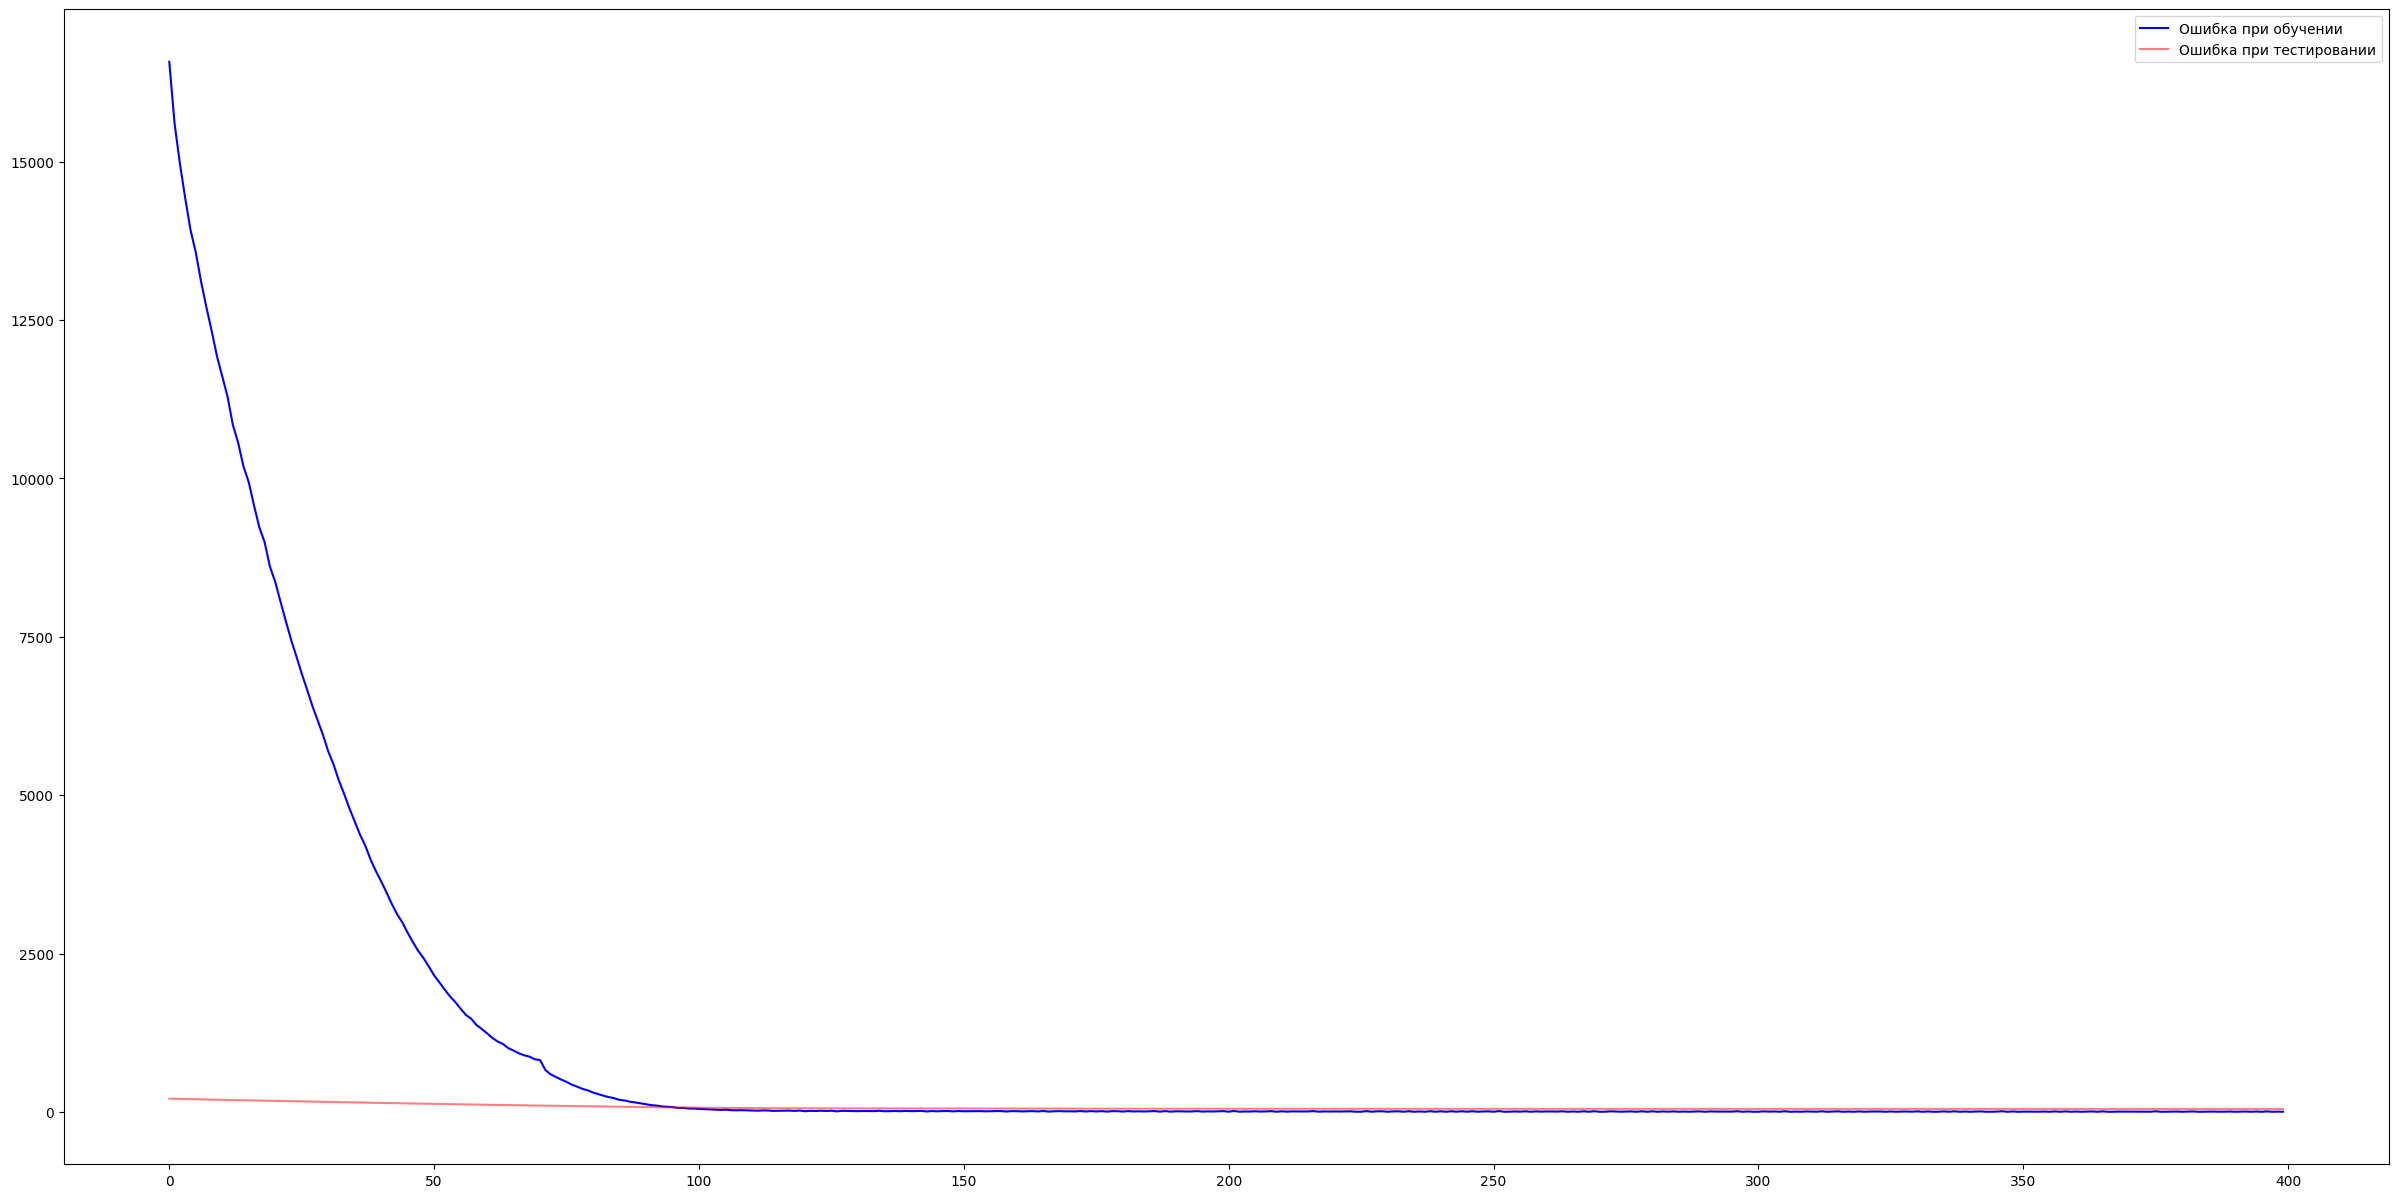

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(train_loss, c='b', label = 'Ошибка при обучении')
plt.plot(test_loss_rms, c='r', label = 'Ошибка при тестировании', alpha = 0.5)
plt.legend()
plt.show()

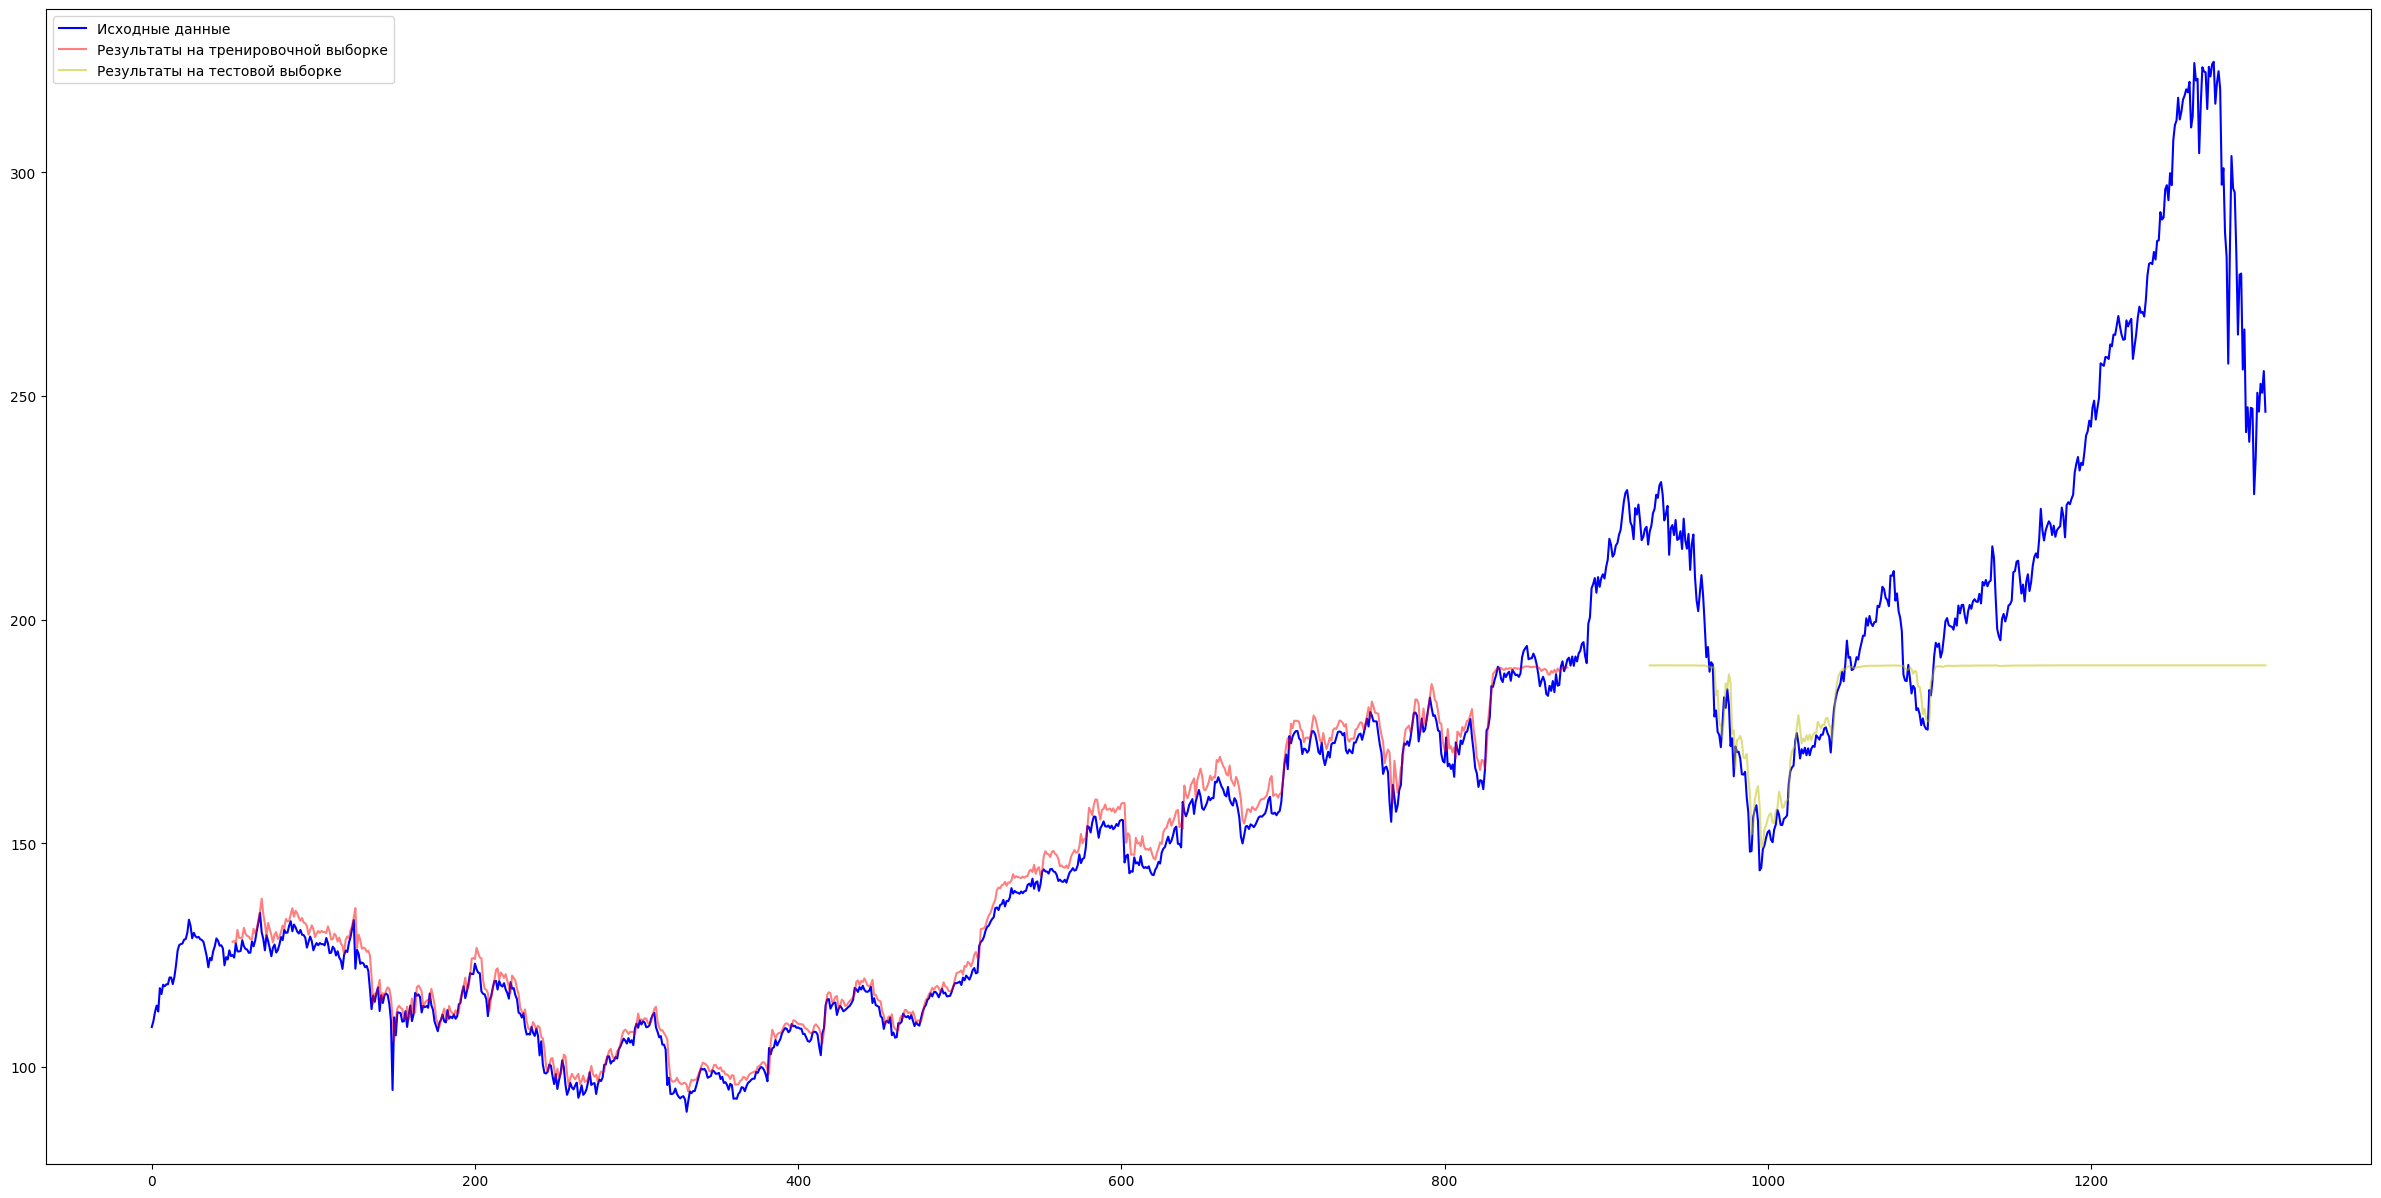

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = rnn(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = rnn(X_train)[:, -1, :].cpu()
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = rnn(X_test)[:, -1, :].cpu()
plt.figure(figsize=(30,15))
plt.plot(timeseries, c='b', label = 'Исходные данные')
plt.plot(train_plot, c='r', label = 'Результаты на тренировочной выборке', alpha = 0.5)
plt.plot(test_plot, c='y', label = 'Результаты на тестовой выборке', alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

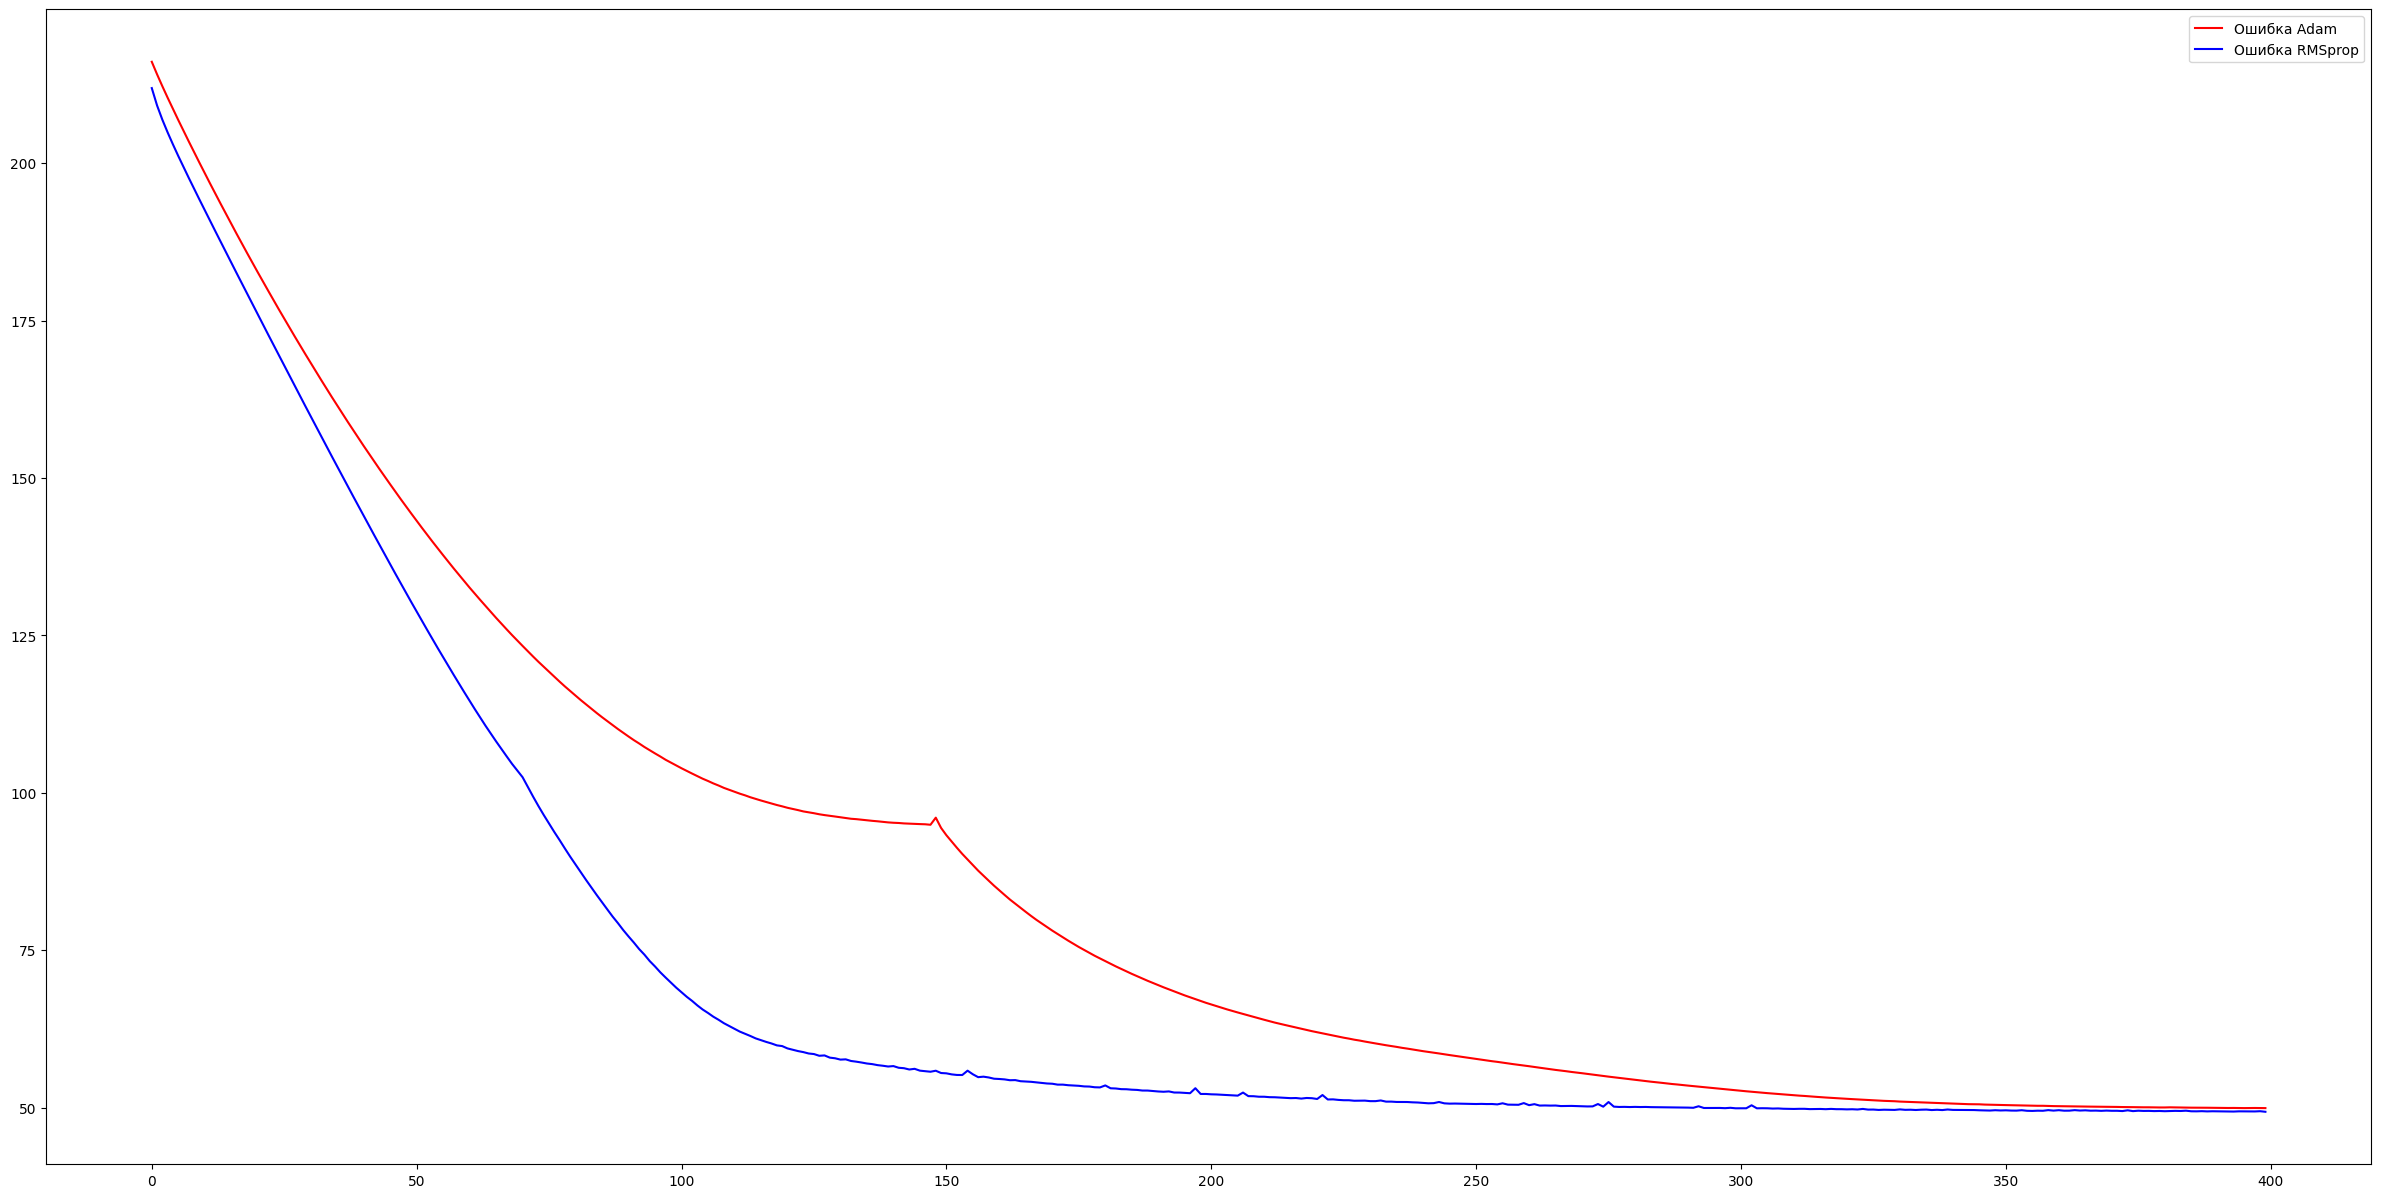

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(test_loss_adam, c='r', label = 'Ошибка Adam')
plt.plot(test_loss_rms, c='b', label = 'Ошибка RMSprop')
plt.legend()
plt.show()

In [ ]:
#END RNN

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 100, batch_first=True)
        self.lstm3 = nn.LSTM(100, 200, batch_first=True)
        self.lstm4 = nn.LSTM(200, 400, batch_first=True)
        self.fc = nn.Linear(400, 50)
        self.fc2 = nn.Linear(50, output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))
    def forward(self, x):
        x, h0 = self.lstm(x)
        x, h1 = self.lstm2(x)
        x, h2 = self.lstm3(x)
        x, h3 = self.lstm4(x)
        x = self.fc(x)
        output = self.fc2(x)
        return output

In [ ]:
#LSTM Adam

In [ ]:
lstm = LSTM().to(device)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train_loss = []
test_loss_adam = []

n_epochs = 120
for epoch in range(n_epochs):
    lstm.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = lstm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    # Валидация
    lstm.eval()
    with torch.no_grad():
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = lstm(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        X_test = X_test.cuda()
        y_pred = lstm(X_test)
        y_test = y_test.cuda()
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_loss_adam.append(test_rmse.item())
    print("%d: среднеквадратичное отклонение на train - %.4f, среднеквадратичное отклонение на test - %.4f" % (epoch, train_rmse, test_rmse))
    print("{}: функция ошибки - {:.5f}".format(epoch, loss.item()))
    print()

0: среднеквадратичное отклонение на train - 71.7852, среднеквадратичное отклонение на test - 156.6550
0: функция ошибки - 5919.97217

1: среднеквадратичное отклонение на train - 28.5777, среднеквадратичное отклонение на test - 87.3877
1: функция ошибки - 673.33521

2: среднеквадратичное отклонение на train - 27.2393, среднеквадратичное отклонение на test - 95.2194
2: функция ошибки - 1082.97729

3: среднеквадратичное отклонение на train - 27.2520, среднеквадратичное отклонение на test - 95.8168
3: функция ошибки - 482.85562

4: среднеквадратичное отклонение на train - 27.2542, среднеквадратичное отклонение на test - 96.0302
4: функция ошибки - 658.60931

5: среднеквадратичное отклонение на train - 27.2047, среднеквадратичное отклонение на test - 94.8304
5: функция ошибки - 866.39050

6: среднеквадратичное отклонение на train - 27.1907, среднеквадратичное отклонение на test - 94.9505
6: функция ошибки - 740.25787

7: среднеквадратичное отклонение на train - 27.1754, среднеквадратичное о

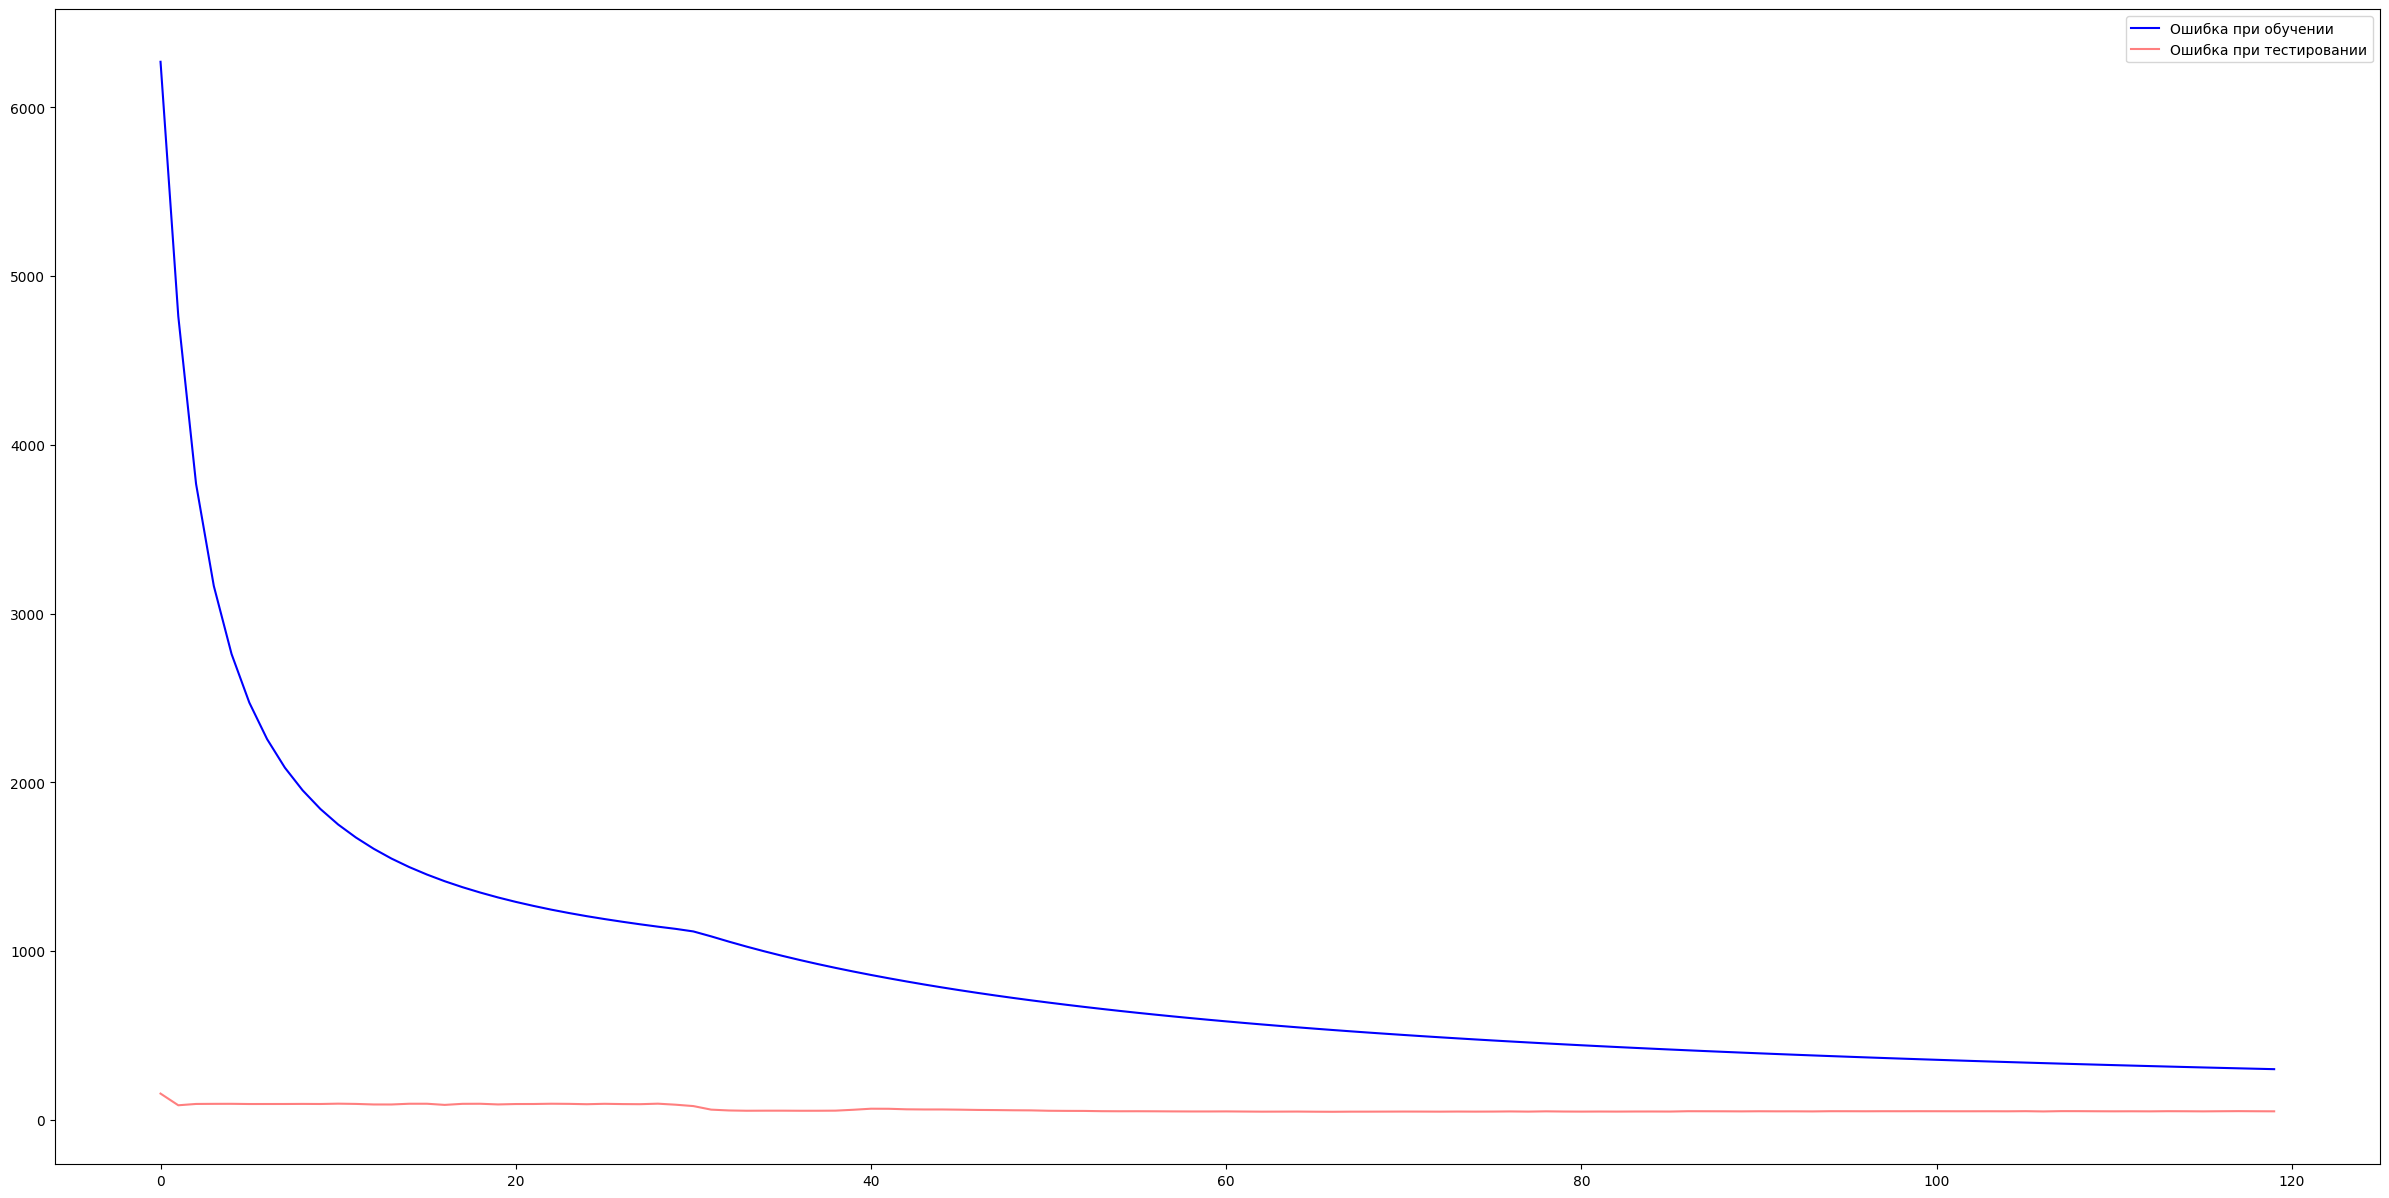

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(train_loss, c='b', label = 'Ошибка при обучении')
plt.plot(test_loss_adam, c='r', label = 'Ошибка при тестировании', alpha = 0.5)
plt.legend()
plt.show()

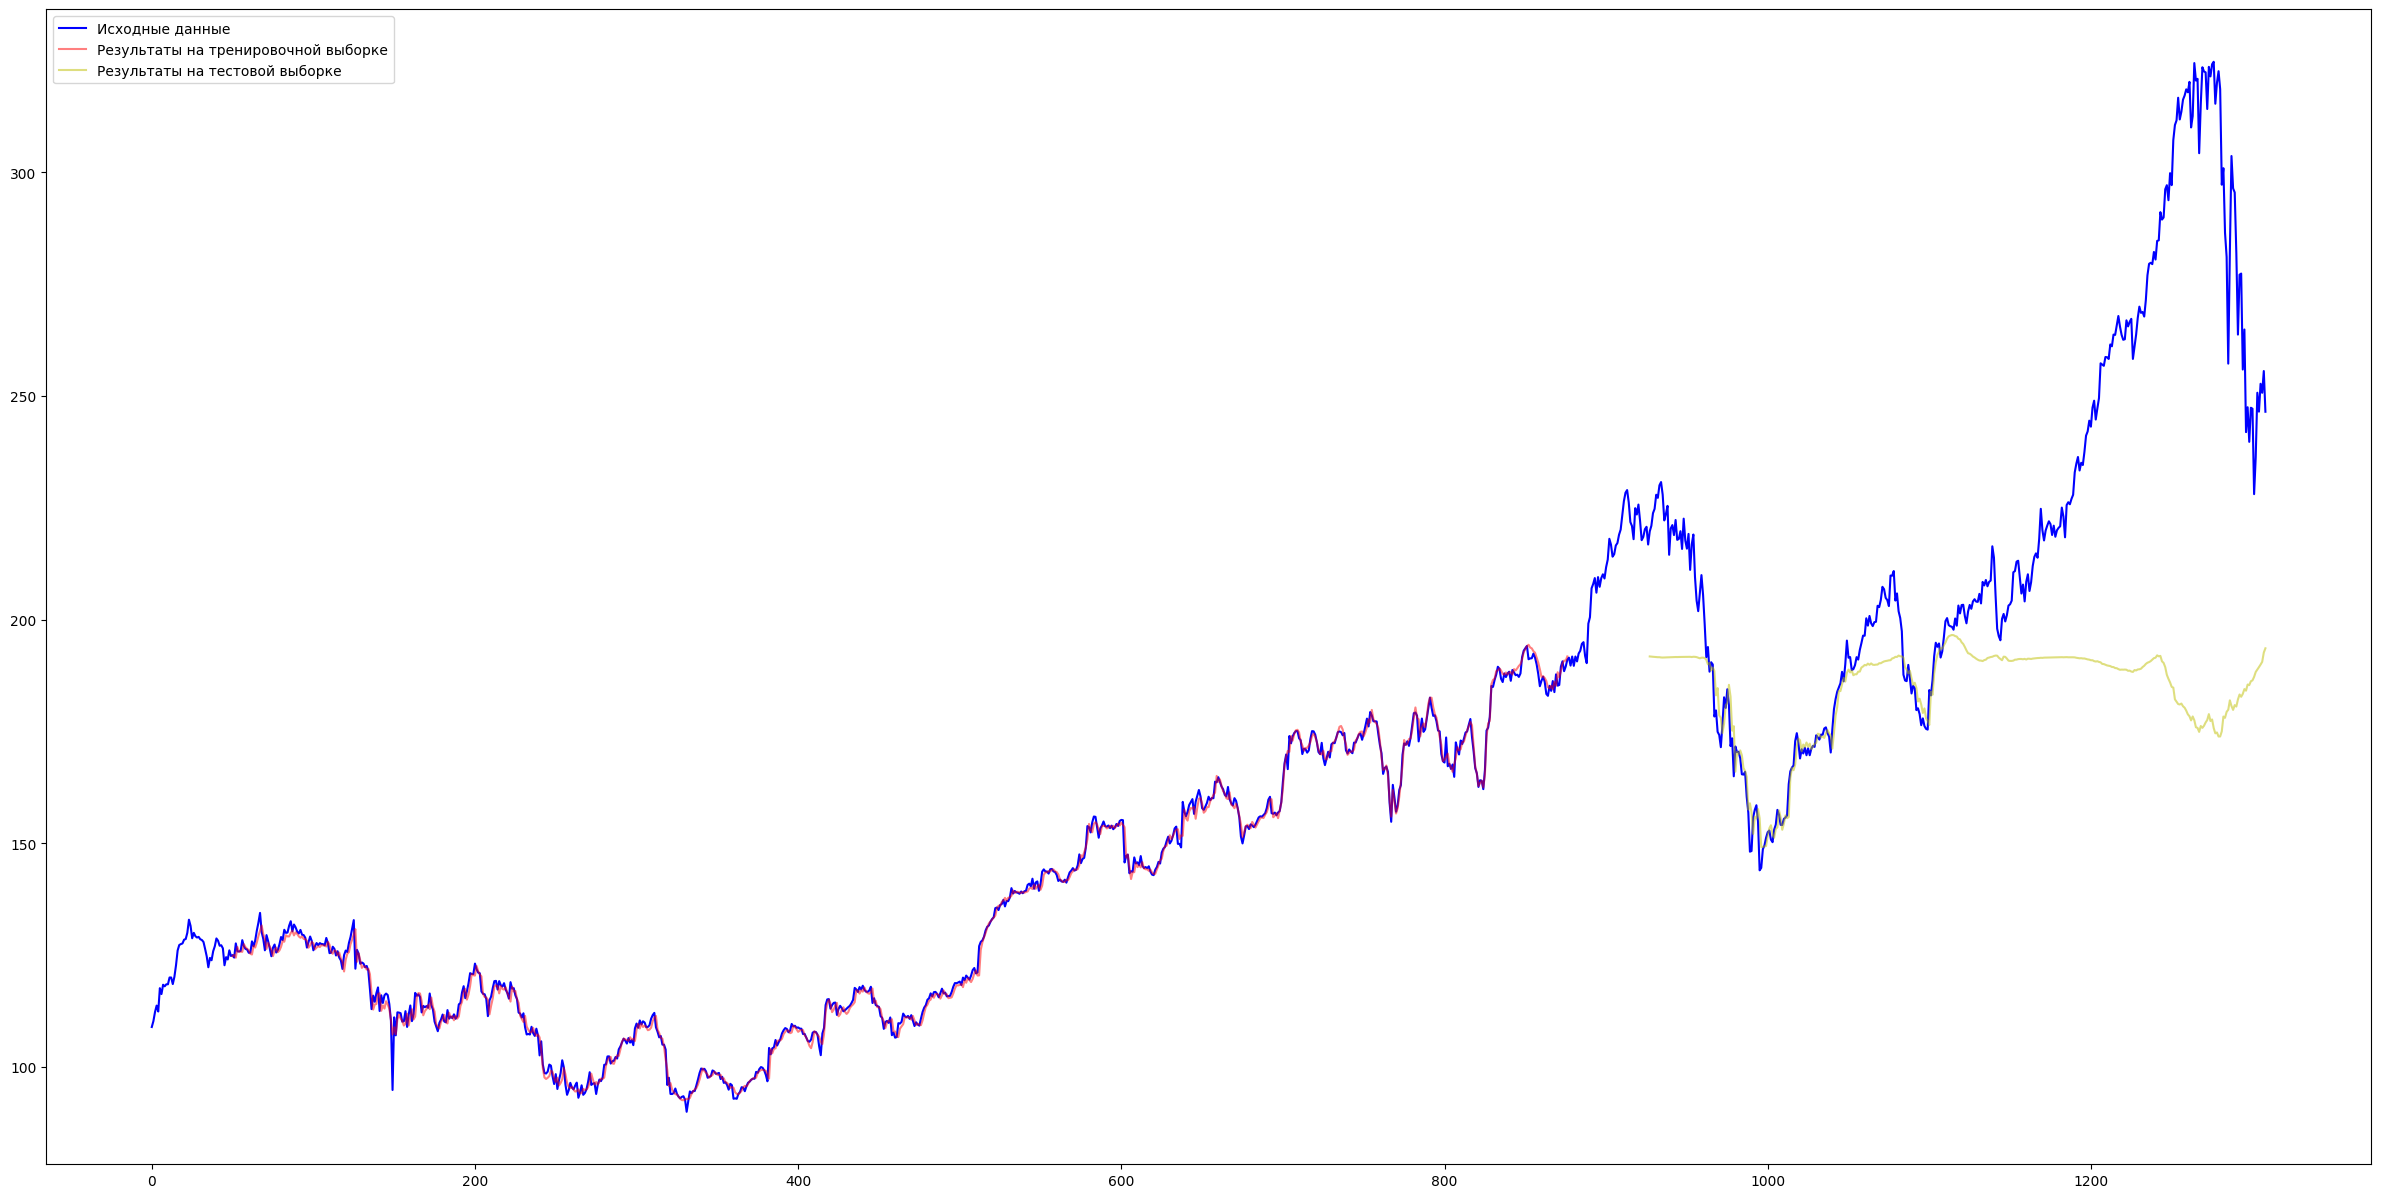

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = lstm(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = lstm(X_train)[:, -1, :].cpu()
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = lstm(X_test)[:, -1, :].cpu()
plt.figure(figsize=(30,15))
plt.plot(timeseries, c='b', label = 'Исходные данные')
plt.plot(train_plot, c='r', label = 'Результаты на тренировочной выборке', alpha = 0.5)
plt.plot(test_plot, c='y', label = 'Результаты на тестовой выборке', alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#LSTM RMS

In [ ]:
lstm = LSTM().to(device)
optimizer = optim.RMSprop(lstm.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train_loss = []
test_loss_rms = []

n_epochs = 120
for epoch in range(n_epochs):
    lstm.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = lstm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    # Валидация
    lstm.eval()
    with torch.no_grad():
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = lstm(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        X_test = X_test.cuda()
        y_pred = lstm(X_test)
        y_test = y_test.cuda()
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_loss_rms.append(test_rmse.item())
    print("%d: среднеквадратичное отклонение на train - %.4f, среднеквадратичное отклонение на test - %.4f" % (epoch, train_rmse, test_rmse))
    print("{}: функция ошибки - {:.5f}".format(epoch, loss.item()))
    print()

0: среднеквадратичное отклонение на train - 27.3915, среднеквадратичное отклонение на test - 97.1854
0: функция ошибки - 824.80786

1: среднеквадратичное отклонение на train - 27.0157, среднеквадратичное отклонение на test - 94.9353
1: функция ошибки - 882.08362

2: среднеквадратичное отклонение на train - 26.8816, среднеквадратичное отклонение на test - 94.4522
2: функция ошибки - 515.31458

3: среднеквадратичное отклонение на train - 22.4921, среднеквадратичное отклонение на test - 90.4555
3: функция ошибки - 273.80573

4: среднеквадратичное отклонение на train - 16.9726, среднеквадратичное отклонение на test - 73.9806
4: функция ошибки - 374.14261

5: среднеквадратичное отклонение на train - 7.6713, среднеквадратичное отклонение на test - 64.6075
5: функция ошибки - 76.91209

6: среднеквадратичное отклонение на train - 7.3809, среднеквадратичное отклонение на test - 65.3975
6: функция ошибки - 70.33842

7: среднеквадратичное отклонение на train - 10.1502, среднеквадратичное отклонен

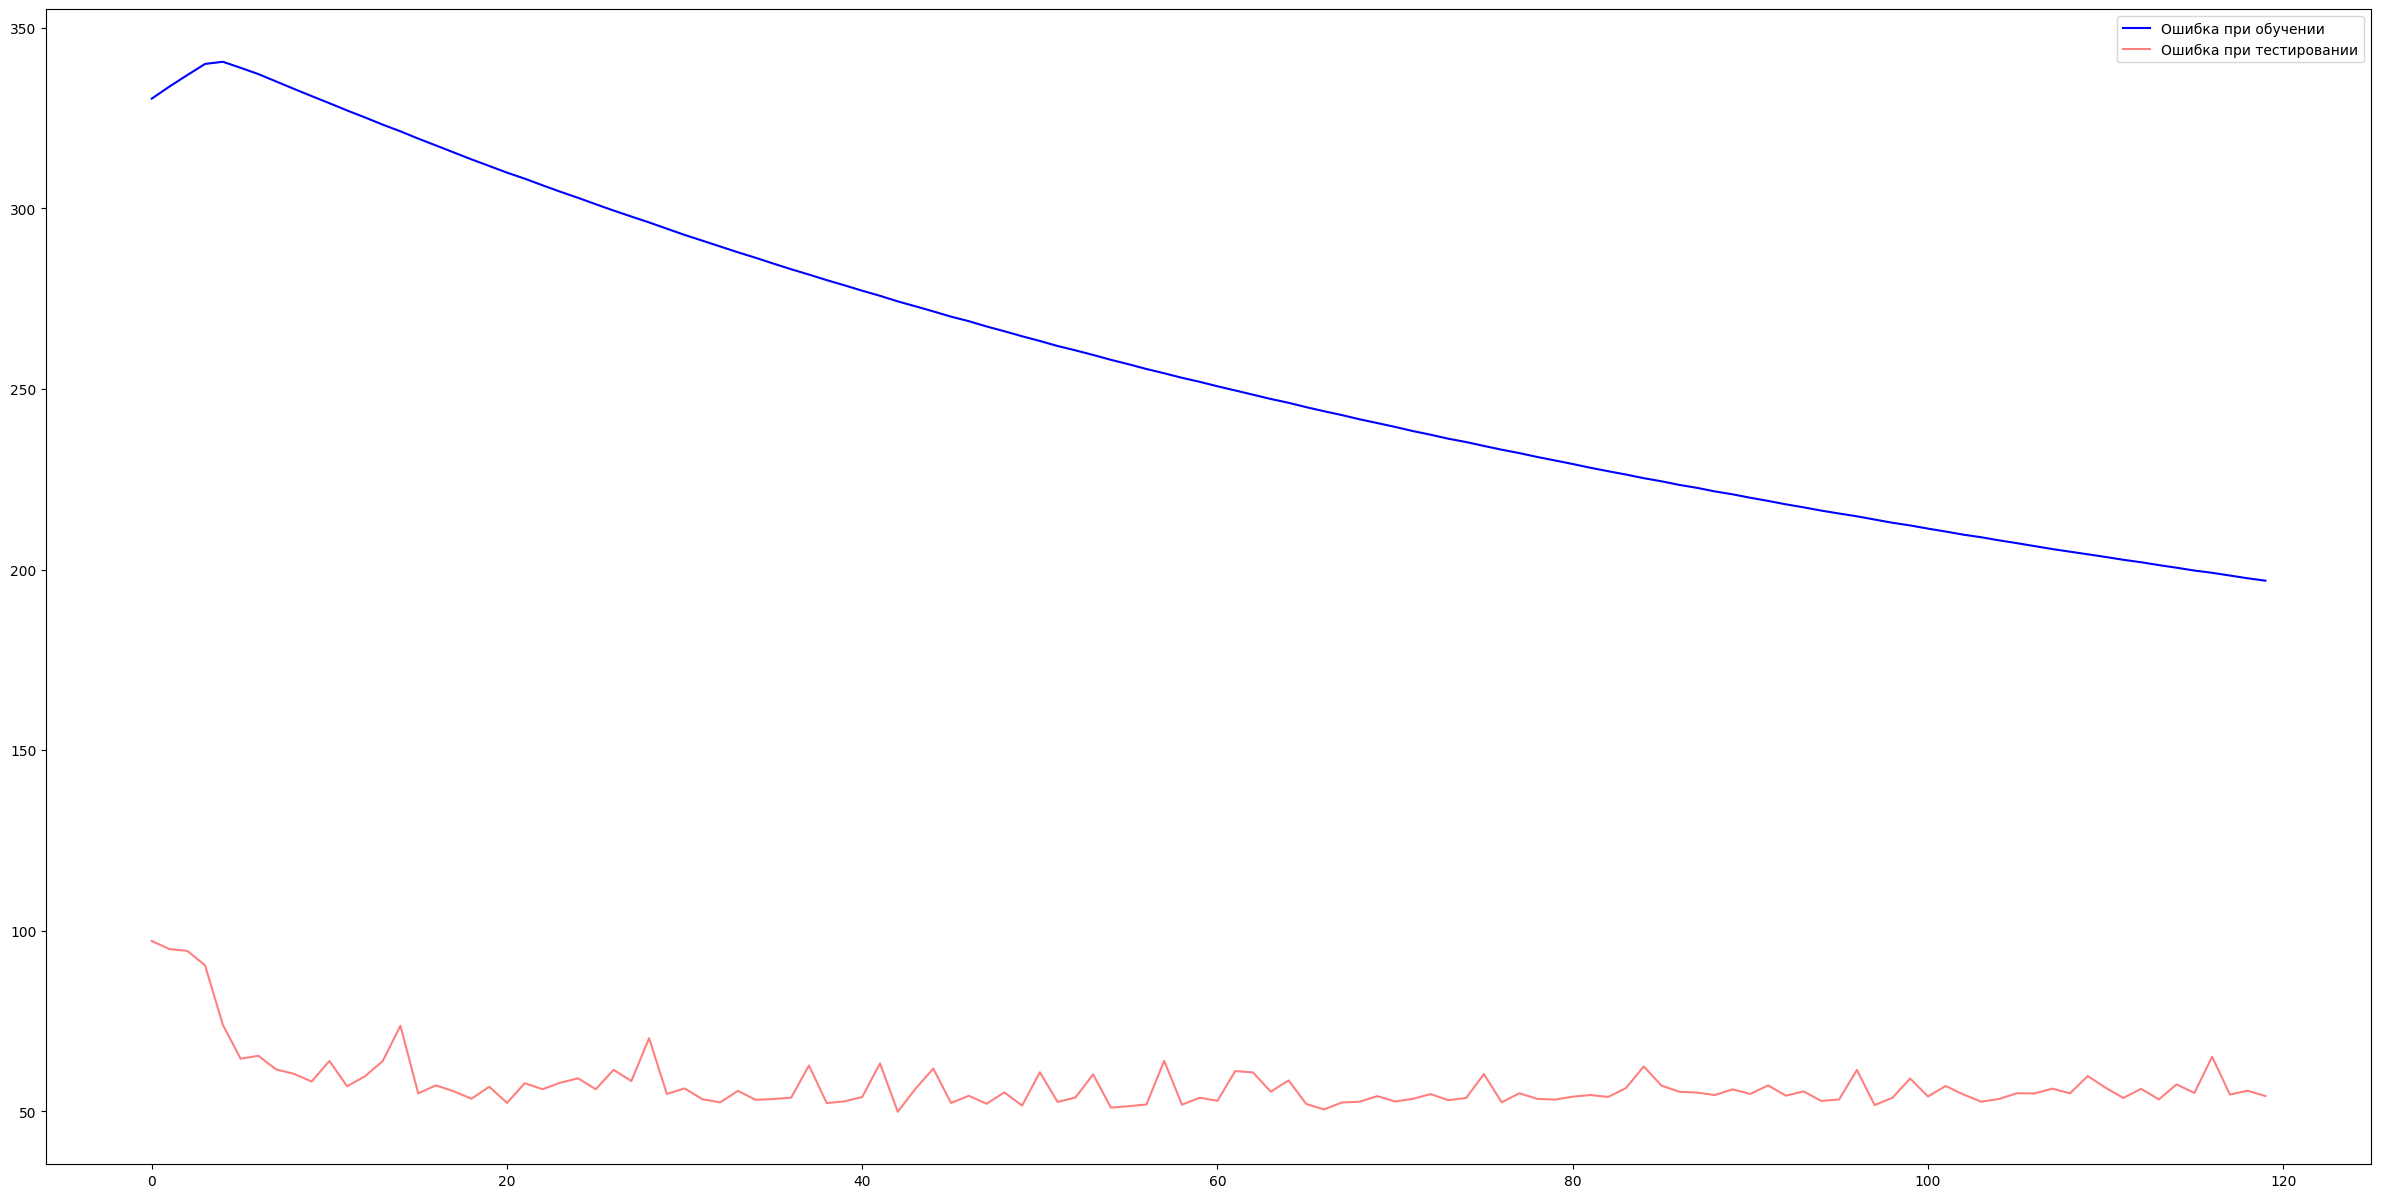

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(train_loss, c='b', label = 'Ошибка при обучении')
plt.plot(test_loss_rms, c='r', label = 'Ошибка при тестировании', alpha = 0.5)
plt.legend()
plt.show()

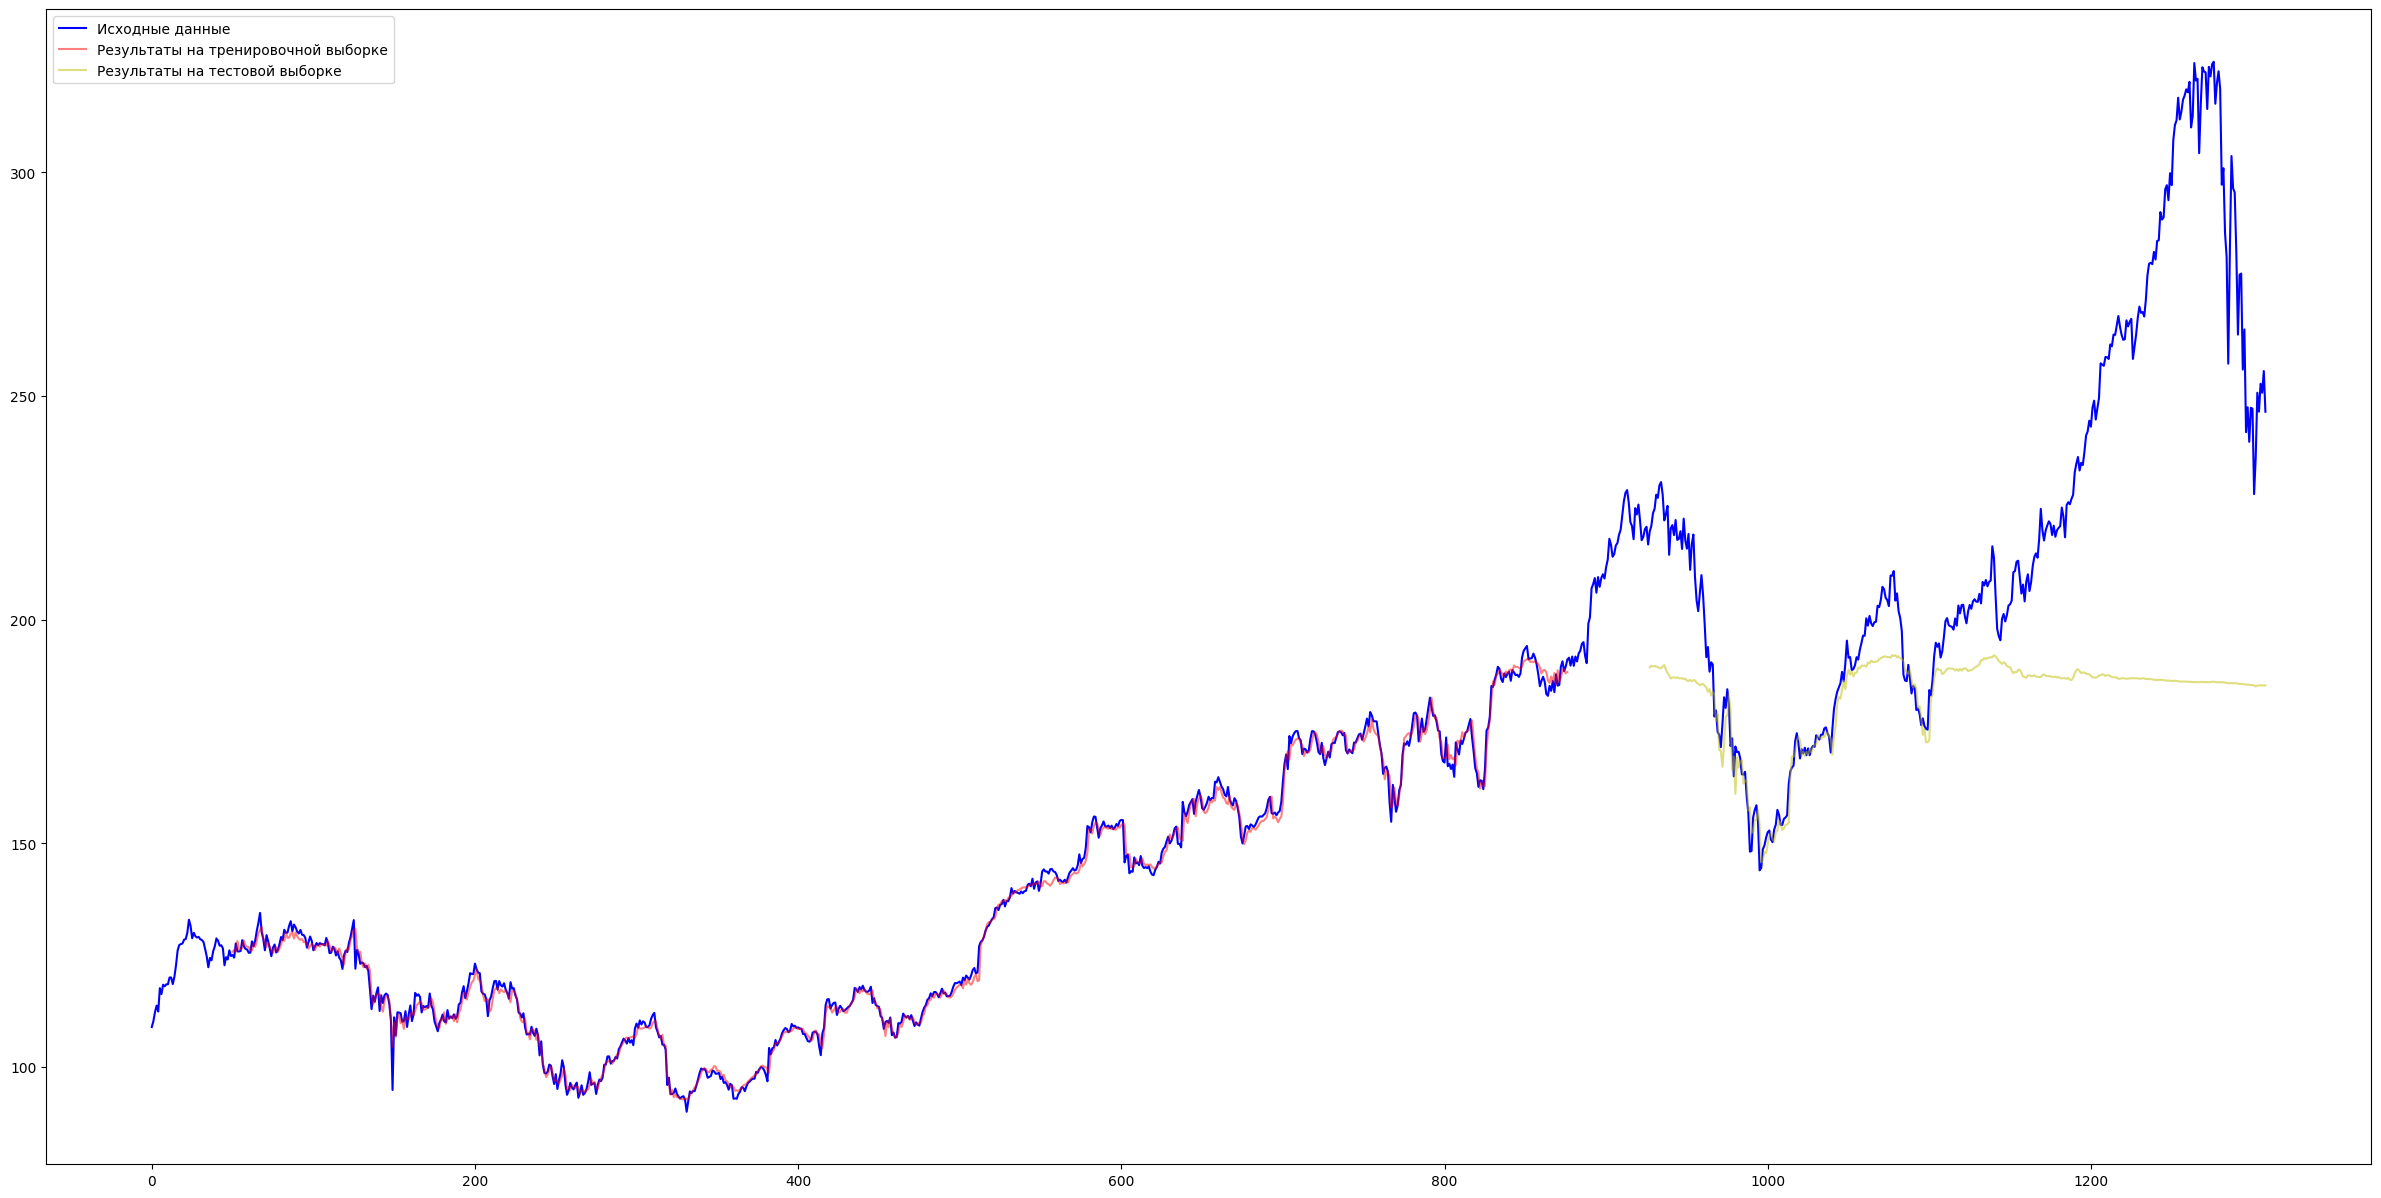

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = lstm(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = lstm(X_train)[:, -1, :].cpu()
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = lstm(X_test)[:, -1, :].cpu()
plt.figure(figsize=(30,15))
plt.plot(timeseries, c='b', label = 'Исходные данные')
plt.plot(train_plot, c='r', label = 'Результаты на тренировочной выборке', alpha = 0.5)
plt.plot(test_plot, c='y', label = 'Результаты на тестовой выборке', alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

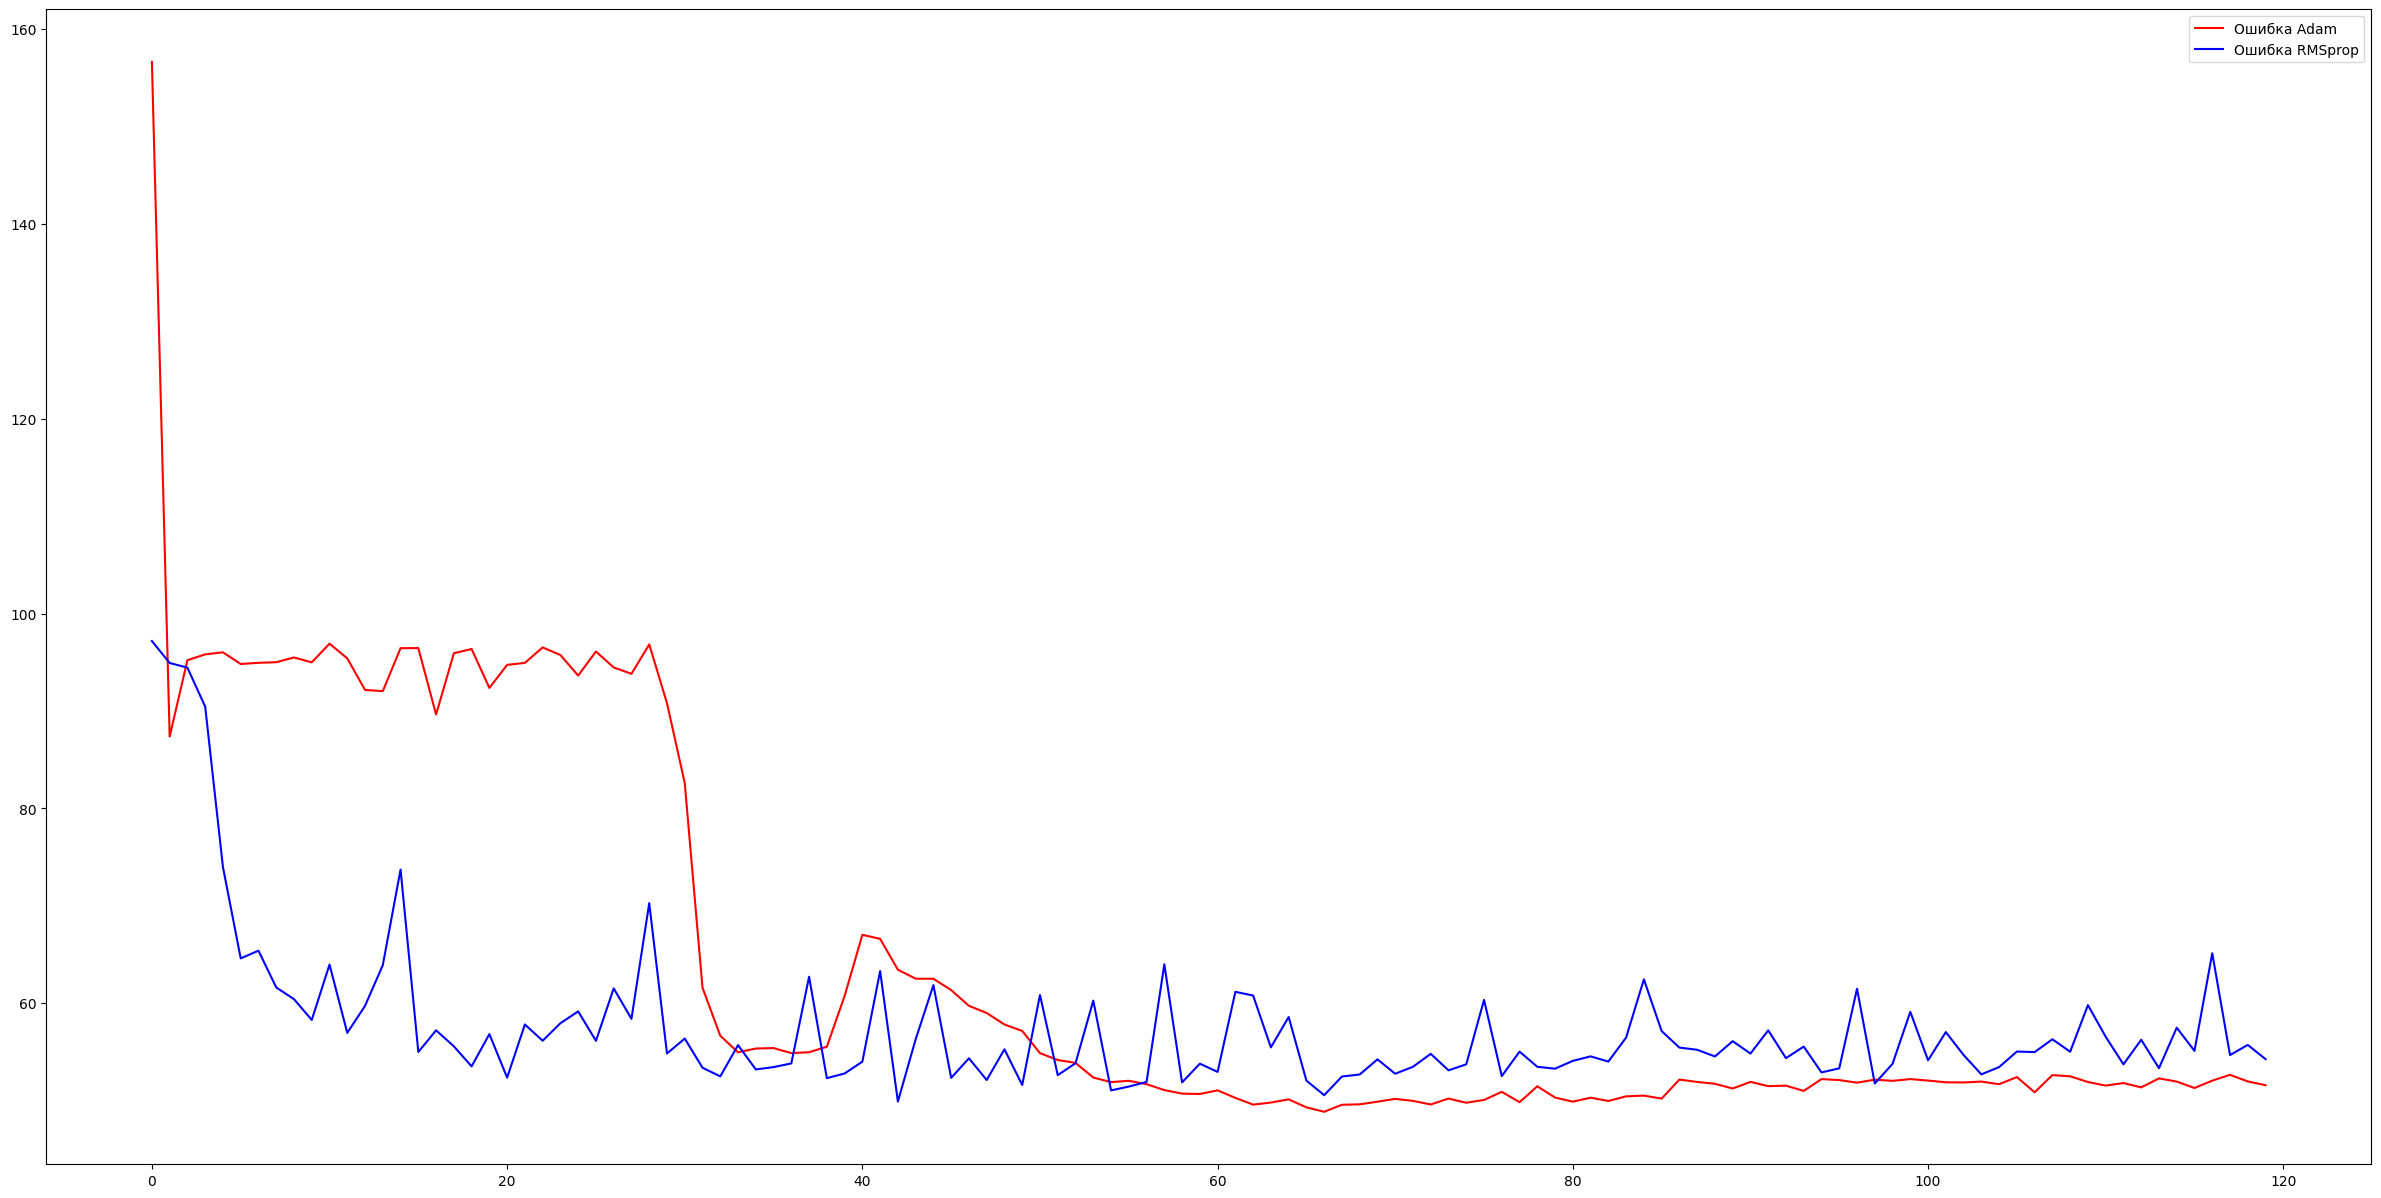

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(test_loss_adam, c='r', label = 'Ошибка Adam')
plt.plot(test_loss_rms, c='b', label = 'Ошибка RMSprop')
plt.legend()
plt.show()

In [ ]:
#END LSTM

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1,
                 layer_dim=2):
        super(GRU, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True)

        self.gru1 = nn.GRU(
            hidden_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        out, h1 = self.gru(x, h0.detach())
        out, _ = self.gru1(out, h1.detach())
        out = self.fc(out)

        return out

In [ ]:
#GRU Adam

In [ ]:
gru = GRU().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.001)

In [ ]:
n_epochs = 1000
train_loss = []
test_loss_adam = []
for epoch in range(n_epochs):
    gru.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = gru(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    gru.eval()
    with torch.no_grad():
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = gru(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        X_test = X_test.cuda()
        y_pred = gru(X_test)
        y_test = y_test.cuda()
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_loss_adam.append(test_rmse.item())
    print("%d: среднеквадратичное отклонение на train - %.4f, среднеквадратичное отклонение на test - %.4f" % (epoch, train_rmse, test_rmse))
    print("{}: функция ошибки - {:.5f}".format(epoch, loss.item()))
    print()

0: среднеквадратичное отклонение на train - 129.6598, среднеквадратичное отклонение на test - 215.4324
0: функция ошибки - 18846.07227

1: среднеквадратичное отклонение на train - 127.4808, среднеквадратичное отклонение на test - 213.2503
1: функция ошибки - 15538.08691

2: среднеквадратичное отклонение на train - 125.5475, среднеквадратичное отклонение на test - 211.3116
2: функция ошибки - 15855.44043

3: среднеквадратичное отклонение на train - 123.6959, среднеквадратичное отклонение на test - 209.4556
3: функция ошибки - 16113.96777

4: среднеквадратичное отклонение на train - 121.9067, среднеквадратичное отклонение на test - 207.6609
4: функция ошибки - 16581.24414

5: среднеквадратичное отклонение на train - 120.1392, среднеквадратичное отклонение на test - 205.8878
5: функция ошибки - 13773.62402

6: среднеквадратичное отклонение на train - 118.4093, среднеквадратичное отклонение на test - 204.1516
6: функция ошибки - 12097.11816

7: среднеквадратичное отклонение на train - 116.

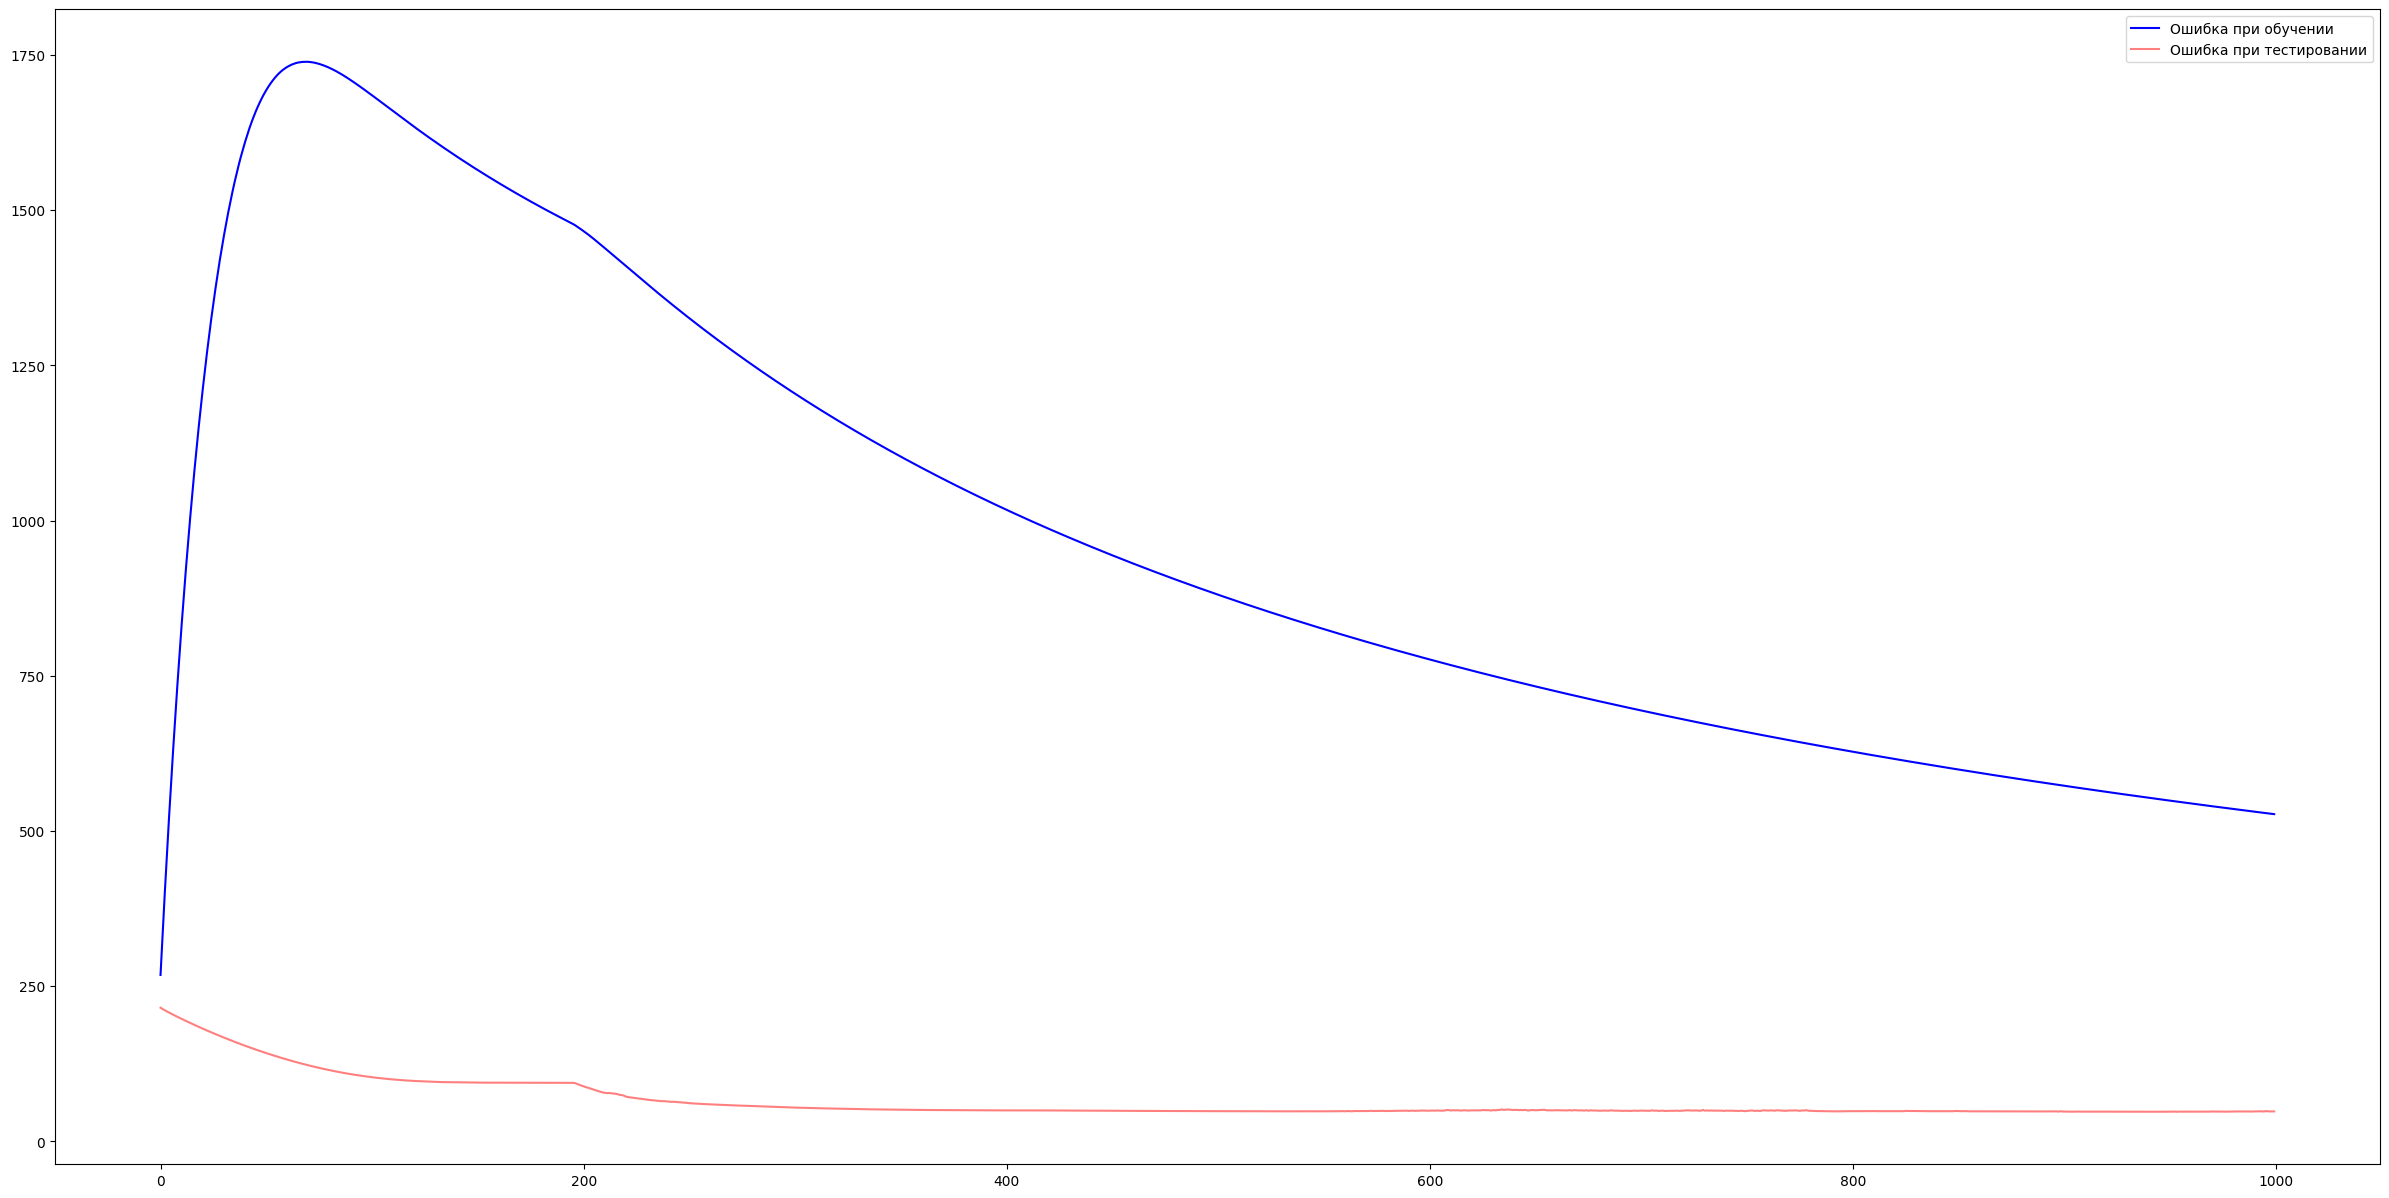

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(train_loss, c='b', label = 'Ошибка при обучении')
plt.plot(test_loss_adam, c='r', label = 'Ошибка при тестировании', alpha = 0.5)
plt.legend()
plt.show()

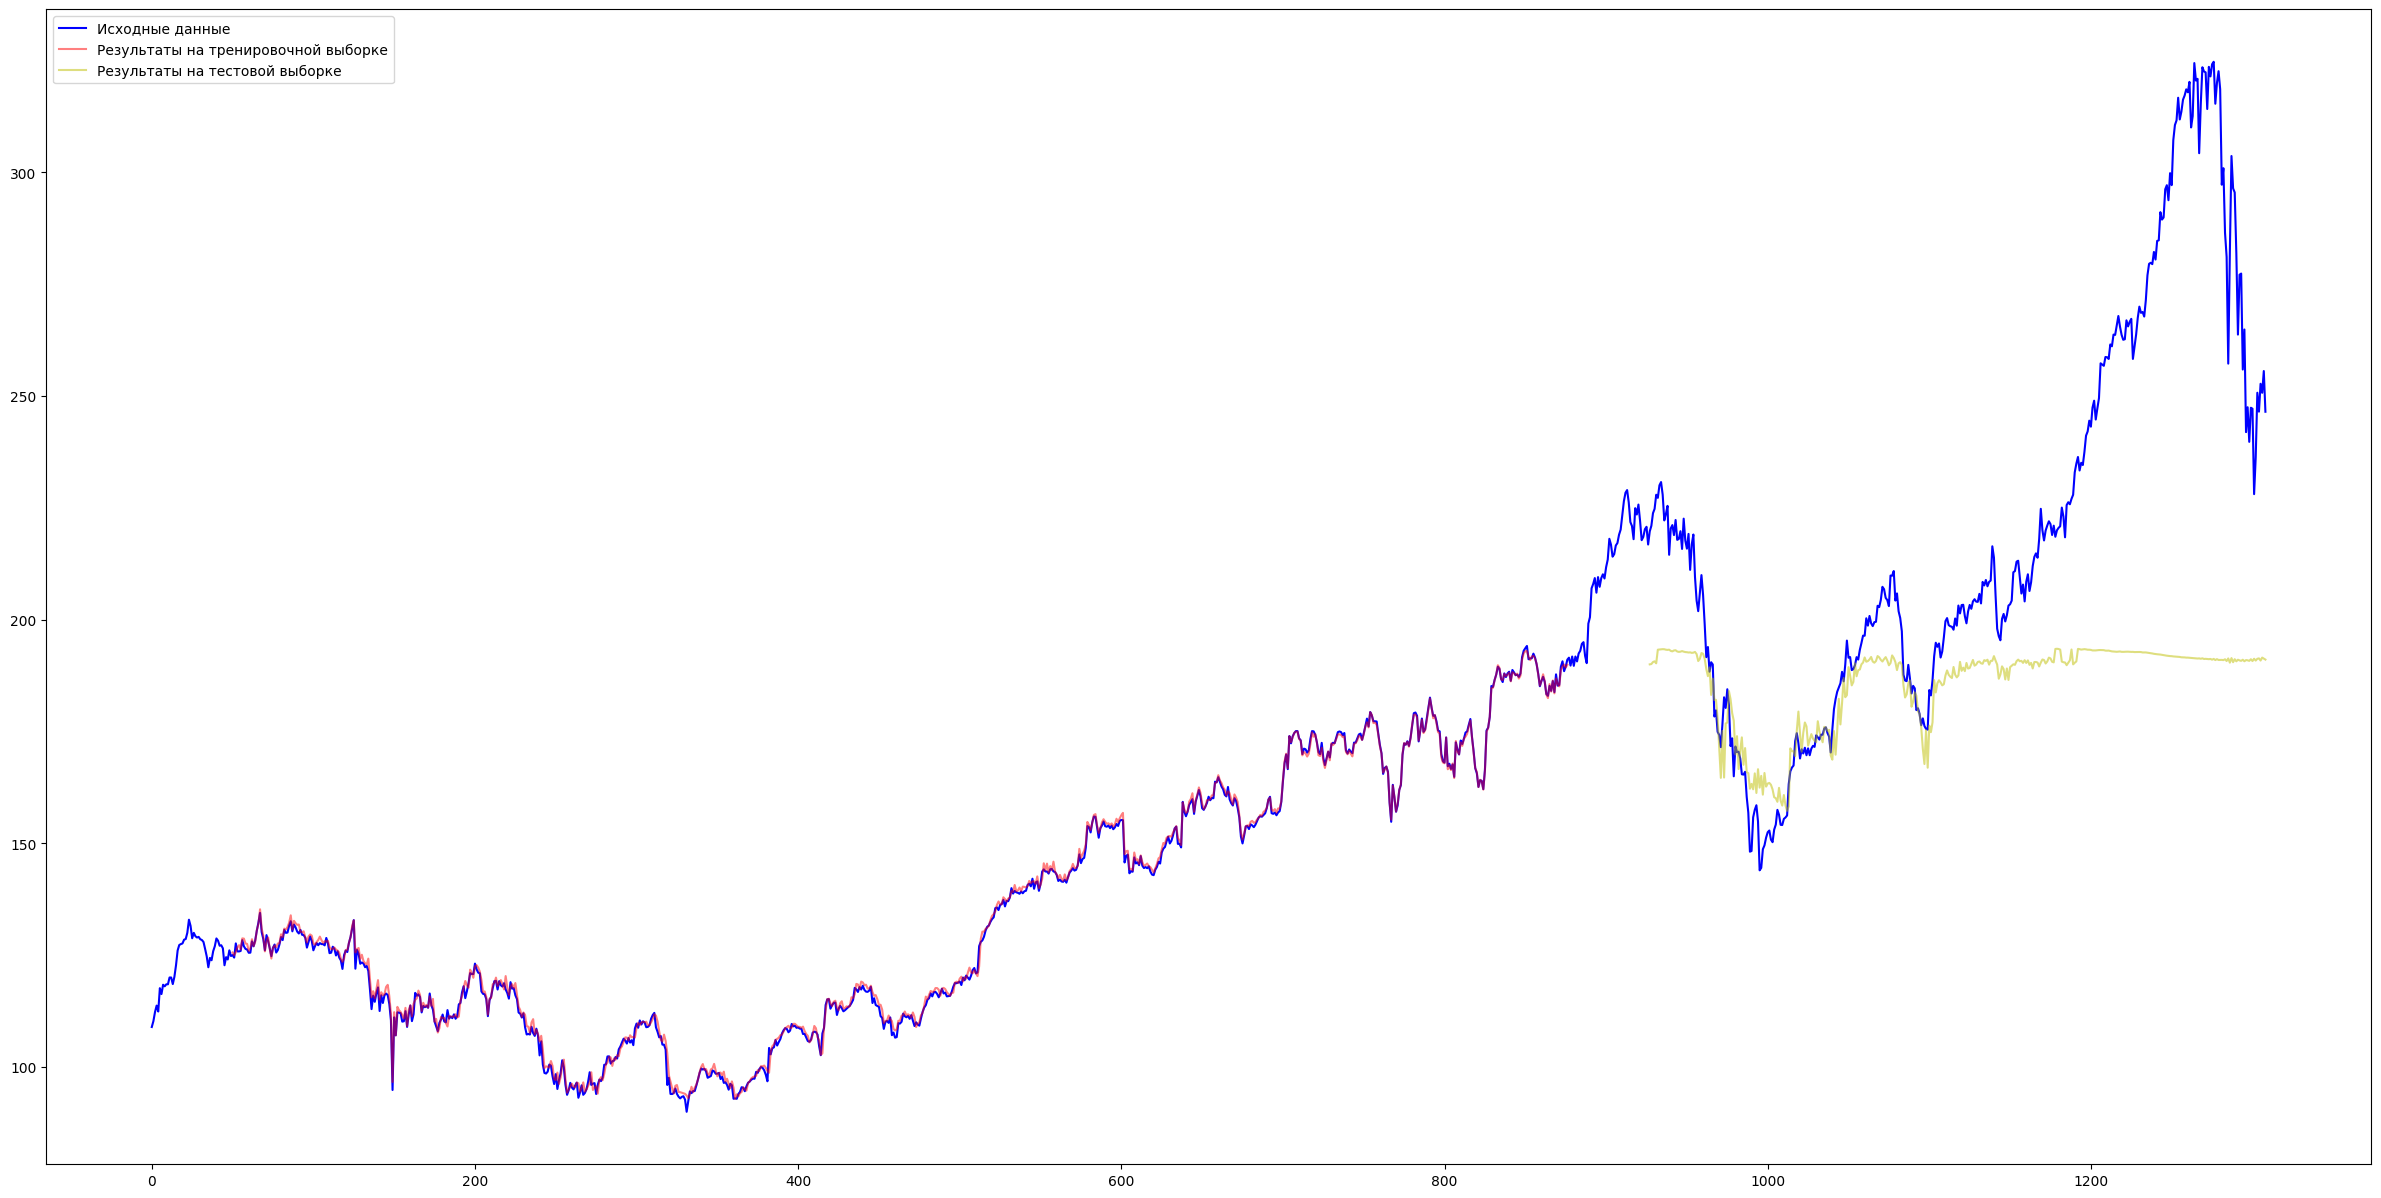

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = gru(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = gru(X_train)[:, -1, :].cpu()
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = gru(X_test)[:, -1, :].cpu()
plt.figure(figsize=(30,15))
plt.plot(timeseries, c='b', label = 'Исходные данные')
plt.plot(train_plot, c='r', label = 'Результаты на тренировочной выборке', alpha = 0.5)
plt.plot(test_plot, c='y', label = 'Результаты на тестовой выборке', alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#GRU RMS

In [ ]:
gru = GRU().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(gru.parameters(), lr=0.001)

In [ ]:
n_epochs = 1000
train_loss = []
test_loss_rms = []
for epoch in range(n_epochs):
    gru.train()
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = gru(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    train_loss.append(np.mean(batch_loss))
    gru.eval()
    with torch.no_grad():
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = gru(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        X_test = X_test.cuda()
        y_pred = gru(X_test)
        y_test = y_test.cuda()
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        test_loss_rms.append(test_rmse.item())
    print("%d: среднеквадратичное отклонение на train - %.4f, среднеквадратичное отклонение на test - %.4f" % (epoch, train_rmse, test_rmse))
    print("{}: функция ошибки - {:.5f}".format(epoch, loss.item()))
    print()

0: среднеквадратичное отклонение на train - 125.3385, среднеквадратичное отклонение на test - 211.1022
0: функция ошибки - 14133.58887

1: среднеквадратичное отклонение на train - 122.5605, среднеквадратичное отклонение на test - 208.3168
1: функция ошибки - 14790.69531

2: среднеквадратичное отклонение на train - 120.3068, среднеквадратичное отклонение на test - 206.0559
2: функция ошибки - 11469.91797

3: среднеквадратичное отклонение на train - 118.2830, среднеквадратичное отклонение на test - 204.0249
3: функция ошибки - 12391.96289

4: среднеквадратичное отклонение на train - 116.3797, среднеквадратичное отклонение на test - 202.1138
4: функция ошибки - 14414.90918

5: среднеквадратичное отклонение на train - 114.5629, среднеквадратичное отклонение на test - 200.2889
5: функция ошибки - 12469.66602

6: среднеквадратичное отклонение на train - 112.7932, среднеквадратичное отклонение на test - 198.5105
6: функция ошибки - 16296.99512

7: среднеквадратичное отклонение на train - 111.

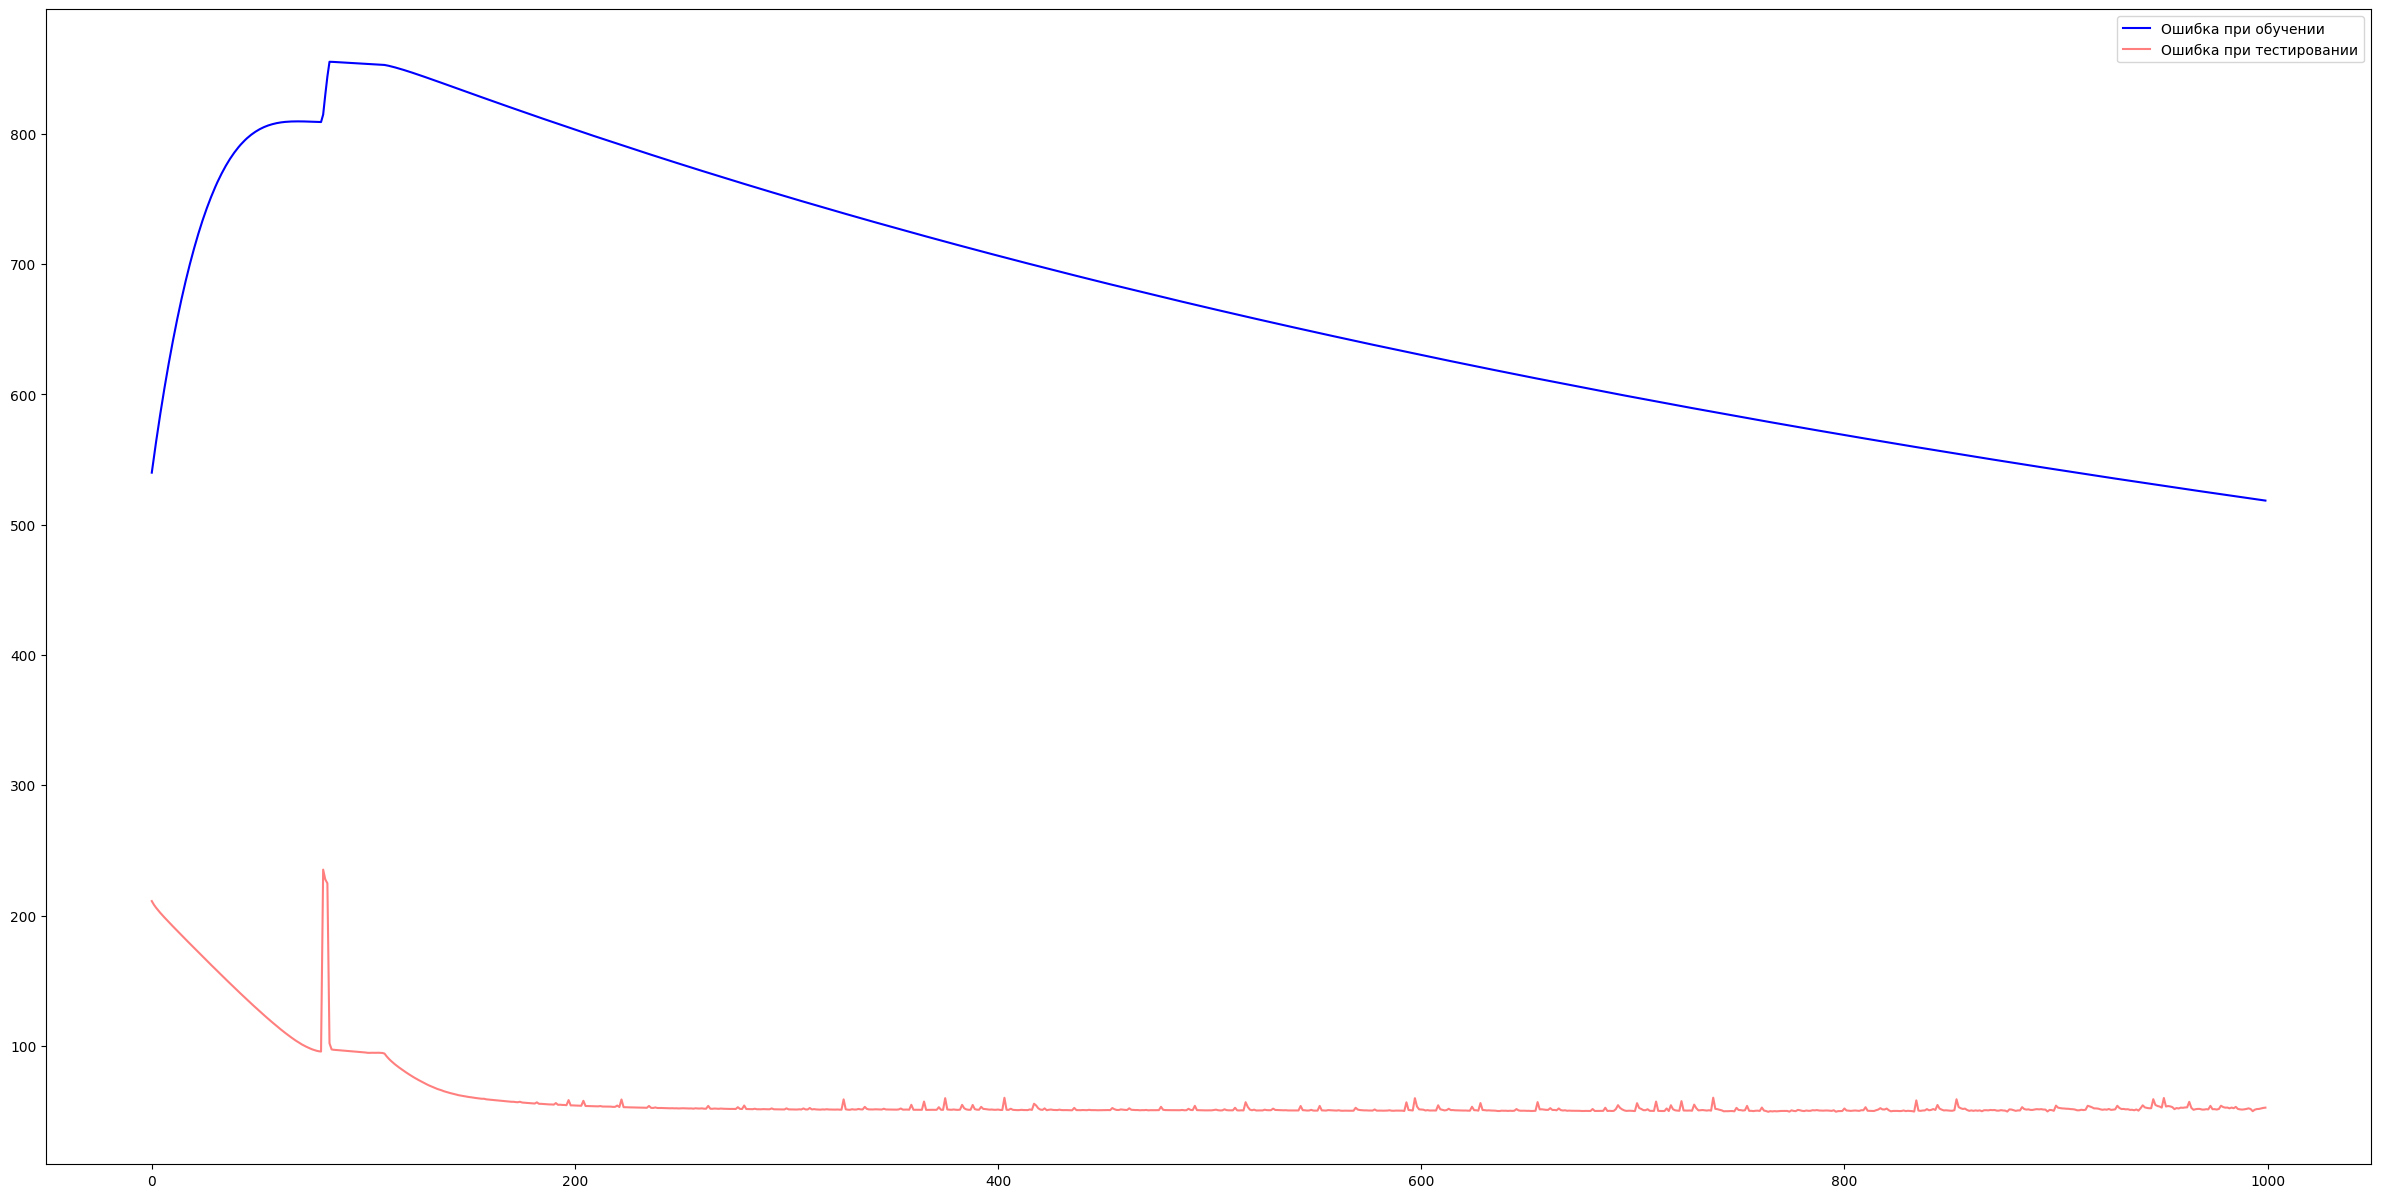

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(train_loss, c='b', label = 'Ошибка при обучении')
plt.plot(test_loss_rms, c='r', label = 'Ошибка при тестировании', alpha = 0.5)
plt.legend()
plt.show()

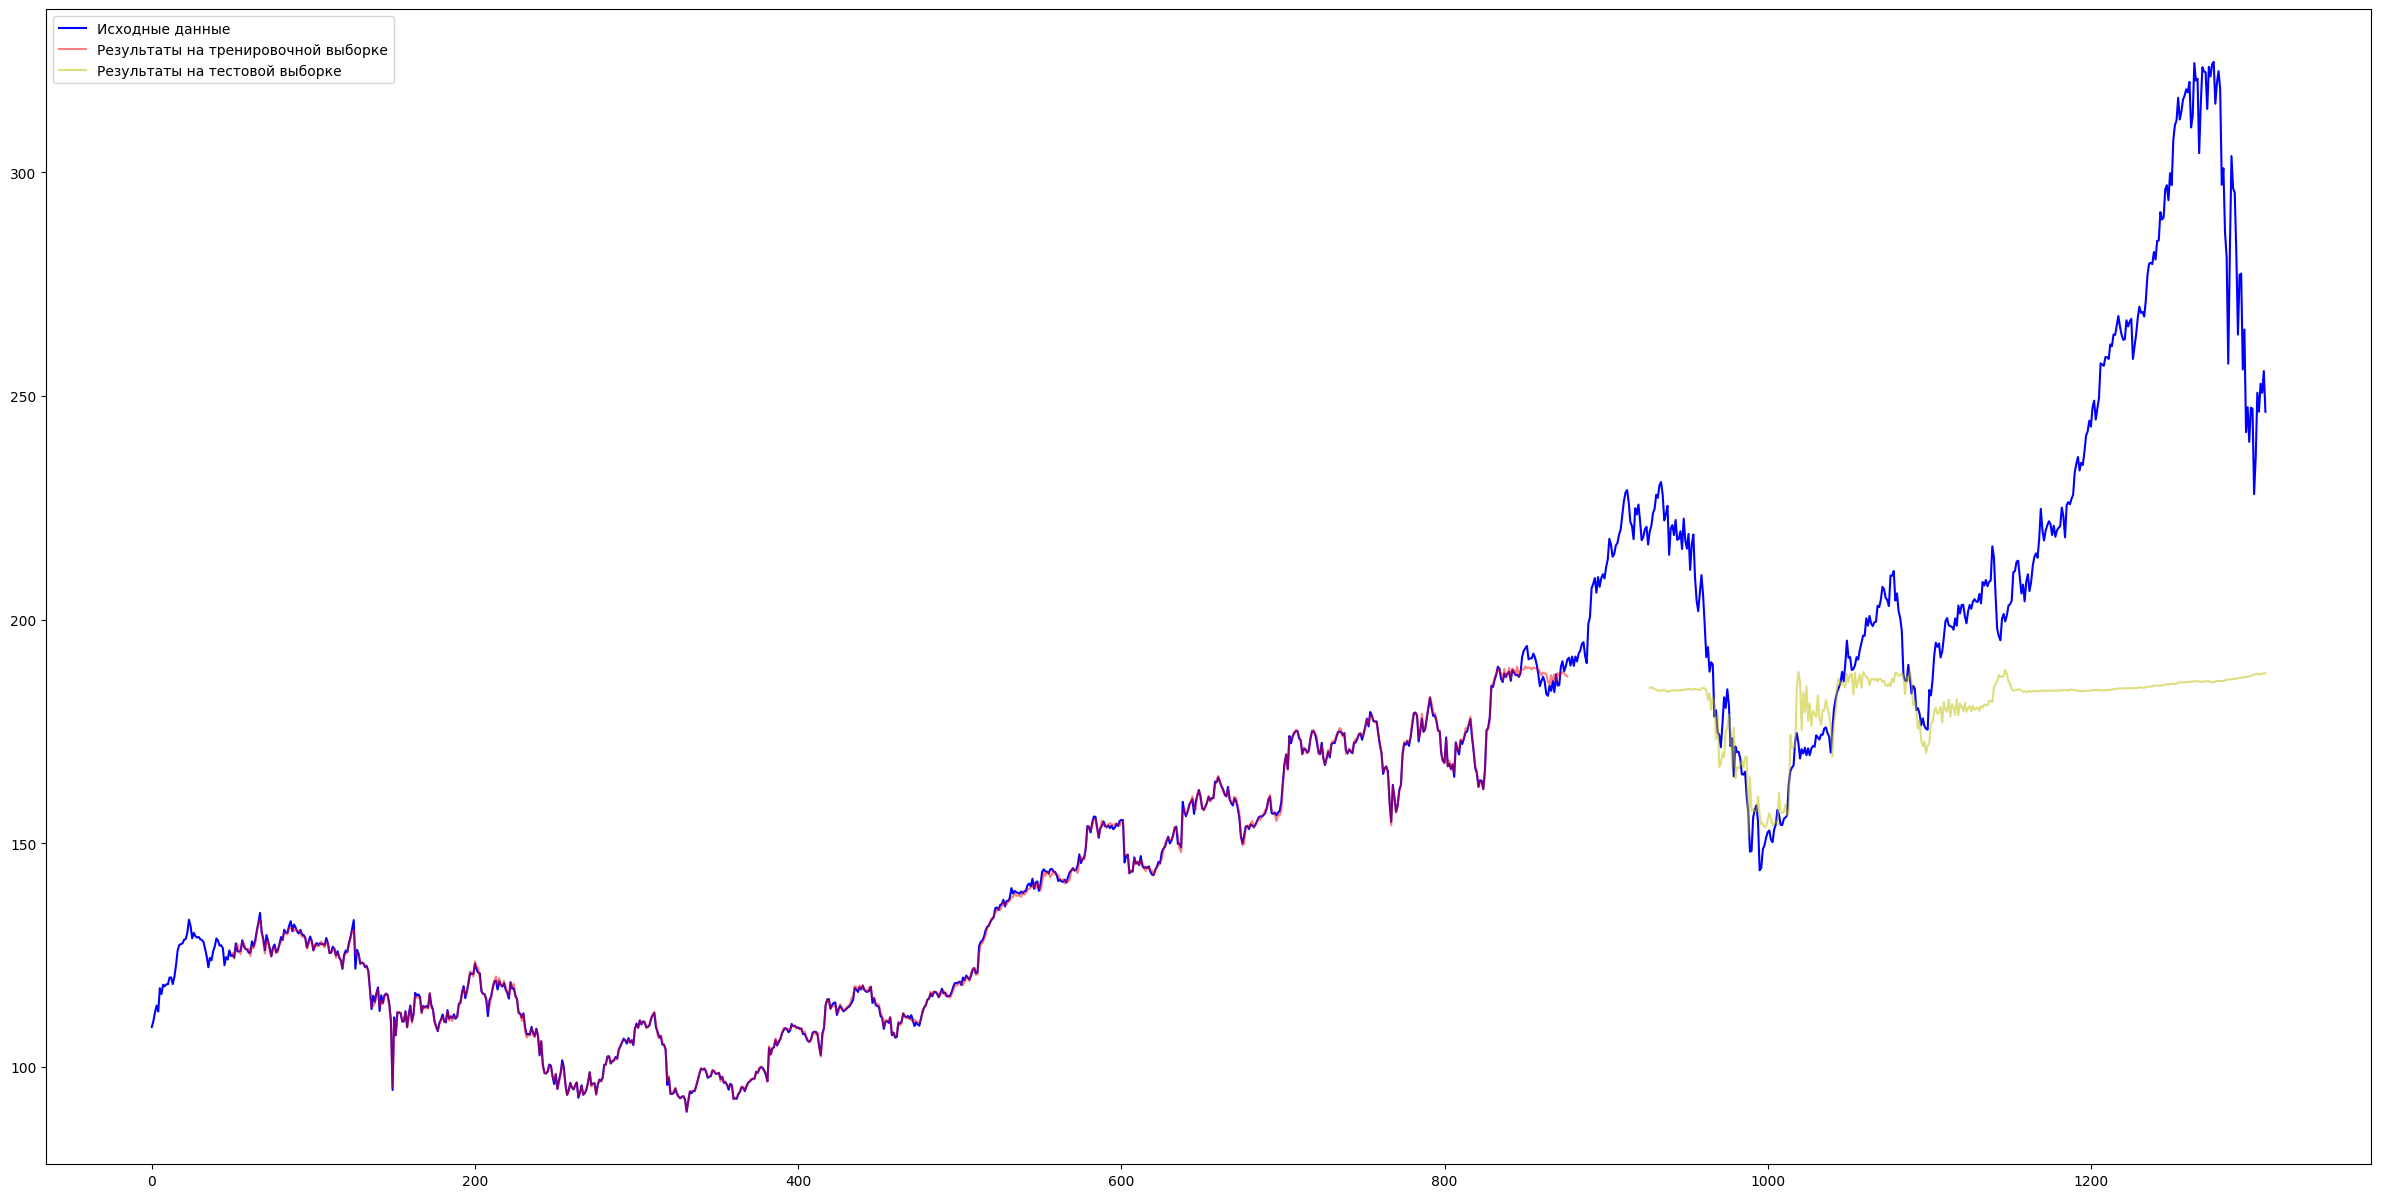

In [ ]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = gru(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = gru(X_train)[:, -1, :].cpu()
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = gru(X_test)[:, -1, :].cpu()
plt.figure(figsize=(30,15))
plt.plot(timeseries, c='b', label = 'Исходные данные')
plt.plot(train_plot, c='r', label = 'Результаты на тренировочной выборке', alpha = 0.5)
plt.plot(test_plot, c='y', label = 'Результаты на тестовой выборке', alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

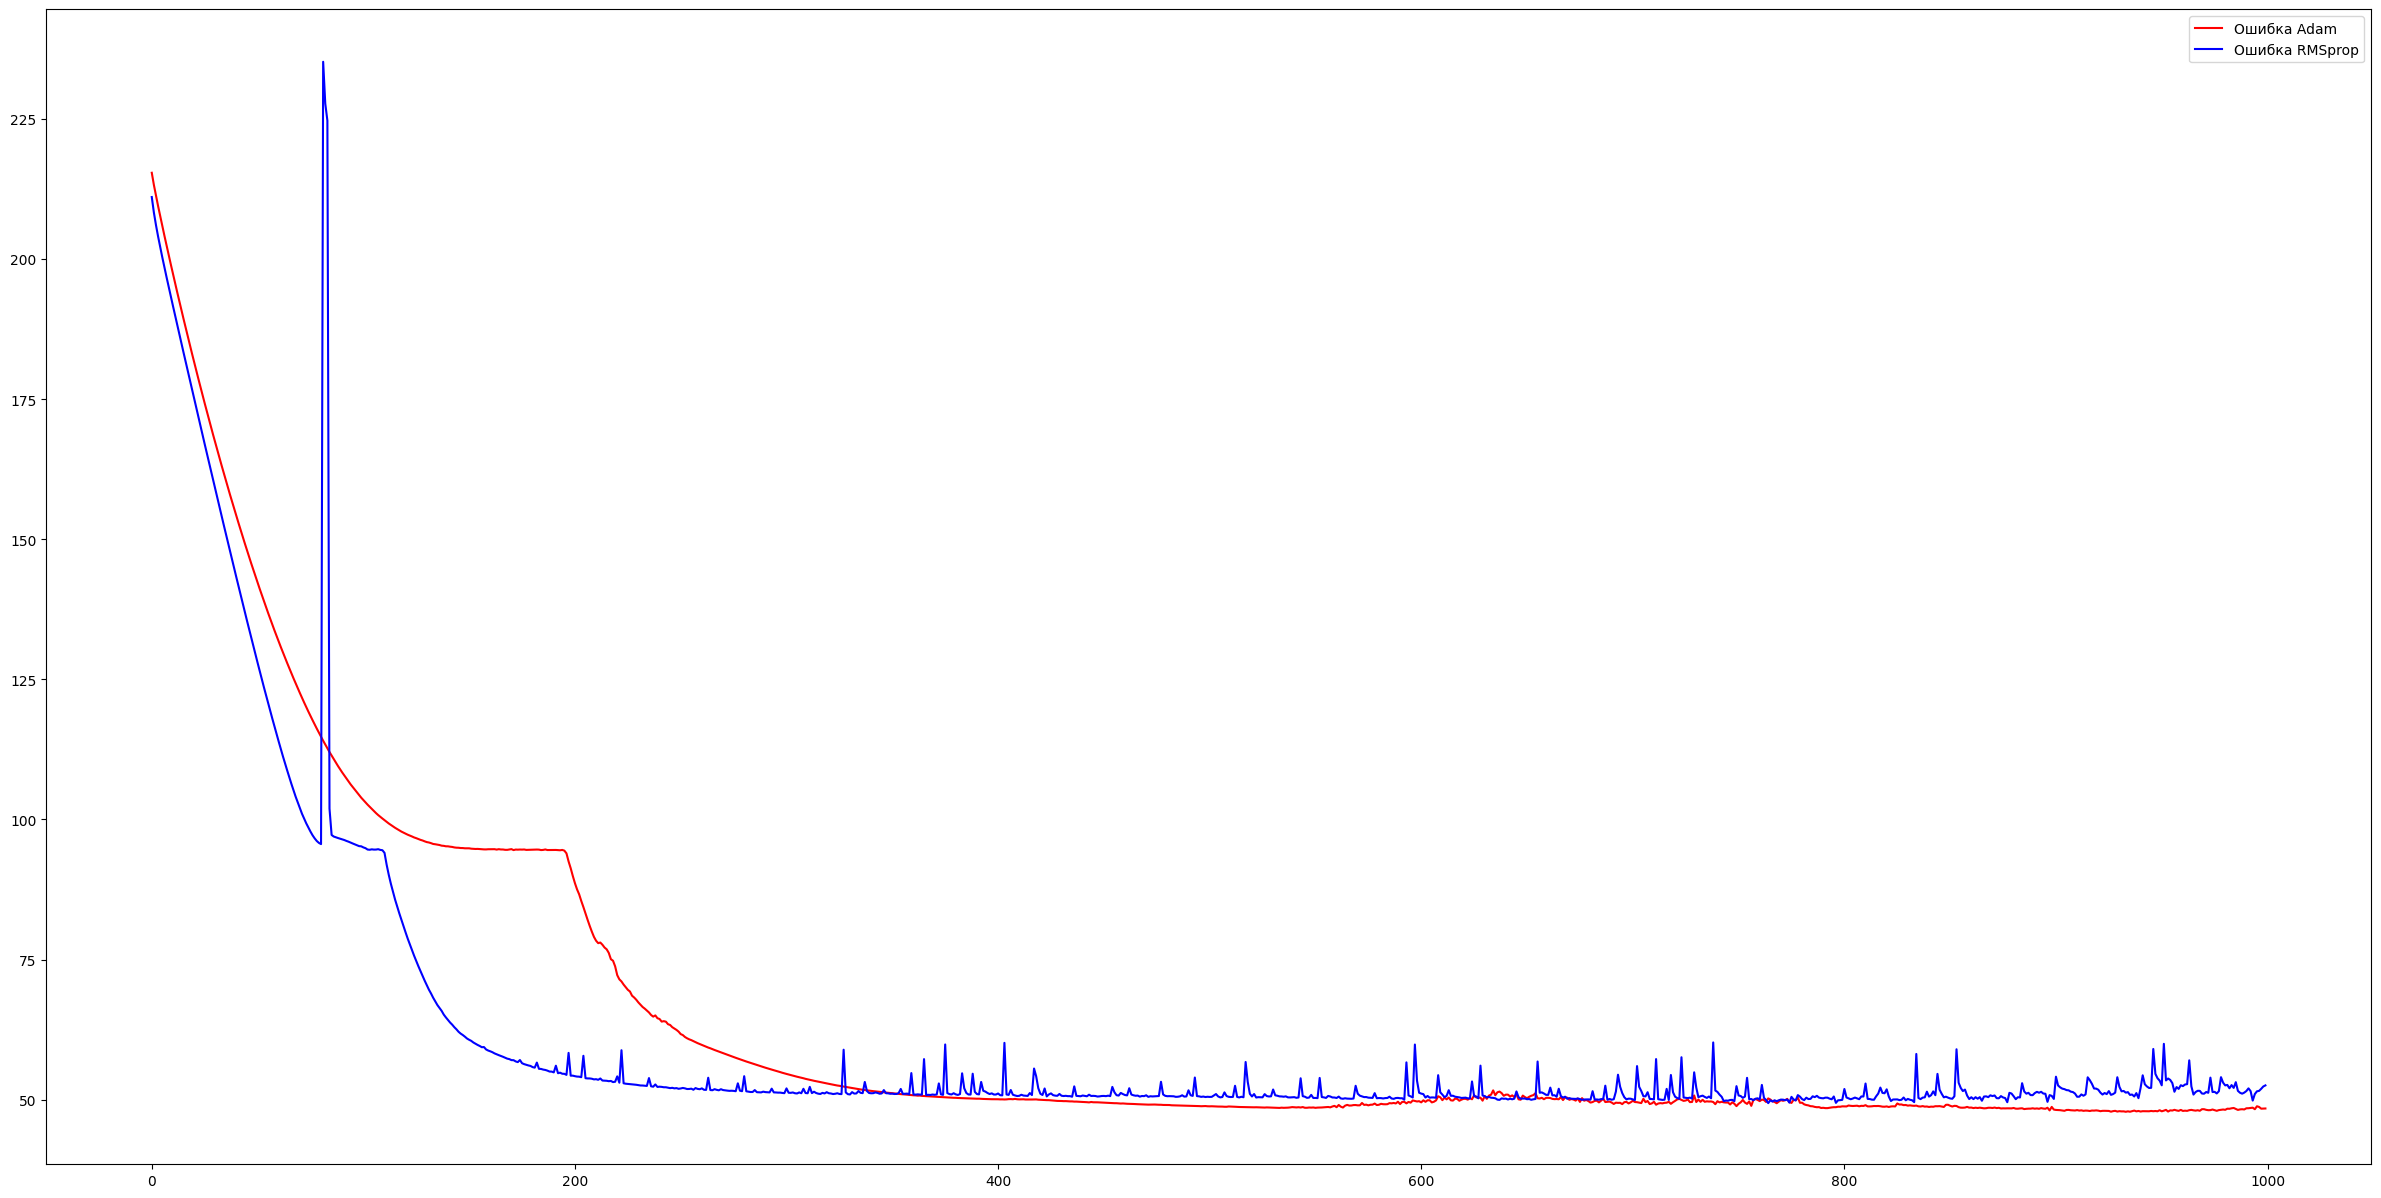

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(test_loss_adam, c='r', label = 'Ошибка Adam')
plt.plot(test_loss_rms, c='b', label = 'Ошибка RMSprop')
plt.legend()
plt.show()

In [ ]:
#END Adam